In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os
import pandas as pd
import matplotlib
matplotlib.style.use('dark_background')
import re
import seaborn as sns
import sys
from datetime import datetime, timedelta
sys.path.append('E:/')
from function import *
import h5py

In [2]:
# Main processing loop for multiple files
pc = 'sophia'
if pc == 'sophia':
    basevol='C:/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'
else:
    basevol = '/Users/ang/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'

### define some columns lists

In [3]:
midpoints = [('headx', 'heady'),('btipx', 'btipy'), ('pelvicfinx', 'pelvicfiny'), ('sdfinx', 'sdfiny'), ('pedunclex', 'peduncley'), ('finx','finy'), ('ttipx', 'ttipy')]
midpoints_centered = [('centered_headx', 'centered_heady'),('centered_btipx', 'centered_btipy'), ('centered_pelvicfinx', 'centered_pelvicfiny'), ('centered_sdfinx', 'centered_sdfiny'), ('centered_pedunclex', 'centered_peduncley'), ('centered_finx','centered_finy'), ('centered_ttipx', 'centered_ttipy')]
midpoints_rotated = [('rotated_headx', 'rotated_heady'),('rotated_btipx', 'rotated_btipy'), ('rotated_pelvicfinx', 'rotated_pelvicfiny'), ('rotated_sdfinx', 'rotated_sdfiny'), ('rotated_pedunclex', 'rotated_peduncley'), ('rotated_finx','rotated_finy'), ('rotated_ttipx', 'rotated_ttipy')]
joints_to_plot = [f'angle_joint_{i}' for i in range(6)]

In [4]:
sharks_df = pd.read_hdf(output_folder + "subset_sharks.h5", key='sharks')

In [5]:
sharks_df.groupby(['Trial', 'ID']).count()

index  SPEED#wcentroid  X#pcentroid  \
Trial                                ID                                        
sequence_20240303_060726300_DJI_0242 0   32889            18034            0   
                                     1   32929            31939            0   
                                     2   32951            14829            0   
                                     3   32943            15092            0   
                                     4   32845            15536            0   
                                     5   32912            18574            0   
sequence_20240303_070126703_DJI_0257 0   72888            61247            0   
                                     1   74898            54422            0   
                                     2   39643            25577            0   
                                     3   43465            24766            0   
sequence_20240303_072831125_DJI_0266 0   44873            43416        43416   
                                     1   52380            51797        51797   
                                     2   43824            43322        43322   
                                     3   51365            48414        48414   
sequence_20240305_063615511_DJI_0253 0   89806            61277            0   
                                     1   82756            32243            0   
                                     2   55034            14016            0   
sequence_20240305_070907124_DJI_0266 0   26637            14022        14021   
                                     1   45665            41281        41281   
sequence_20240305_164039273_DJI_0305 0   47488            46290        46290   
                                     1   47488            38161        38161   
                                     2   47488            41949        41949   
sequence_20240306_161443984_DJI_0139 0   46091            43733        43733   
                                     1   60465            42805        42805   
sequence_20240308_074843321_DJI_0502 0   86813            82479            0   
                                     1   38843            35518            0   

                                         Y#pcentroid  ANGLE  frame   time  \
Trial                                ID                                     
sequence_20240303_060726300_DJI_0242 0             0  18034  32889  32889   
                                     1             0  31939  32929  32929   
                                     2             0  14829  32951  32951   
                                     3             0  15092  32943  32943   
                                     4             0  15536  32845  32845   
                                     5             0  18574  32912  32912   
sequence_20240303_070126703_DJI_0257 0             0      0  72888  72888   
                                     1             0      0  74898  74898   
                                     2             0      0  39643  39643   
                                     3             0      0  43465  43465   
sequence_20240303_072831125_DJI_0266 0         43416  43416  44873  44873   
                                     1         51797  51797  52380  52380   
                                     2         43322  43322  43824  43824   
                                     3         48414  48414  51365  51365   
sequence_20240305_063615511_DJI_0253 0             0      0  89806  89806   
                                     1             0      0  82756  82756   
                                     2             0      0  55034  55034   
sequence_20240305_070907124_DJI_0266 0         14021  14021  26637  26637   
                                     1         41281  41281  45665  45665   
sequence_20240305_164039273_DJI_0305 0         46290  46290  47488  47488   
                                     1         38161  38161  47488  47488   
                             

### standardization of speed

In [6]:
# Group by both 'ID' and 'segment' and count the number of frames for each group
id_segment_counts = sharks_df.groupby(['ID', 'segment','Trial']).size()

# Filter out ID-segment combinations that have less than 100 frames (2 seconds)
id_segments_to_keep = id_segment_counts[id_segment_counts >= 100].index

# Keep only the rows where the combination of 'ID' and 'segment' is in the list of groups with >= 100 frames
sharks_df = sharks_df[sharks_df.set_index(['ID', 'segment', 'Trial']).index.isin(id_segments_to_keep)]

In [7]:
filt_sharks_df = sharks_df[(sharks_df['ID_checked'] == 1) & (sharks_df['drone_movement'] == 0)]

In [8]:
sharks_df.columns

Index(['index', 'SPEED#wcentroid', 'ID', 'X#pcentroid', 'Y#pcentroid', 'ANGLE',
       'frame', 'time', 'headx', 'heady', 'lxfinx', 'lxfiny', 'btipx', 'btipy',
       'rxfinx', 'rxfiny', 'pelvicfinx', 'pelvicfiny', 'sdfinx', 'sdfiny',
       'pedunclex', 'peduncley', 'finx', 'finy', 'ttipx', 'ttipy', 'X', 'Y',
       'segment', 'Trial', 'midpoint_x', 'midpoint_y', 'carangids',
       'drone_movement', 'ID_checked'],
      dtype='object')

In [9]:
import numpy as np
import pandas as pd

def calculate_speed_with_step(df, colx, coly, fps, step_size, max_speed=500000, max_acceleration=500000):
    """
    Calculate speed with a step size within each segment.

    Parameters:
    - df: DataFrame containing the position and frame data.
    - colx: Column name for the x-coordinate.
    - coly: Column name for the y-coordinate.
    - fps: Frames per second of the data.
    - step_size: Number of frames to skip for position differences.
    - max_speed: Maximum allowed speed for filtering outliers.

    Returns:
    - DataFrame with a new 'speed' column added.
    """
    df = df.copy()

    # Ensure frames are sorted correctly before calculation
    df = df.sort_values(by=['ID', 'segment', 'Trial', 'frame']).reset_index(drop=True)

    # Group by ID, segment, and Trial to ensure calculations are within each segment
    df['delta_time'] = df.groupby(['ID', 'segment', 'Trial'])['frame'].diff(periods=step_size) / fps
    df['delta_x'] = df.groupby(['ID', 'segment', 'Trial'])[colx].diff(periods=step_size)
    df['delta_y'] = df.groupby(['ID', 'segment', 'Trial'])[coly].diff(periods=step_size)

    # Calculate speed (avoid division by zero)
    df['speed'] = np.sqrt(df['delta_x']**2 + df['delta_y']**2) / df['delta_time']
    
    # Handle cases where delta_time is zero or NaN (e.g., segment jumps)
    df.loc[df['delta_time'] <= 0, 'speed'] = np.nan

    # Apply filter to remove unrealistically high speeds
    df.loc[df['speed'] > max_speed, 'speed'] = np.nan

    # Drop intermediate columns
    df.drop(columns=['delta_x', 'delta_y'], inplace=True)

    return df

def calculate_speed_per_id_segment(df, colx, coly, fps, step_size, max_speed=500000, max_acceleration=500000):
    """
    Apply speed calculation function for each unique ID, segment, and Trial.

    Parameters:
    - df: DataFrame containing movement data.
    - colx, coly: Column names for x and y coordinates.
    - fps: Frames per second.
    - step_size: Frame step size for speed calculation.
    - max_speed: Maximum allowed speed.

    Returns:
    - DataFrame with calculated speeds.
    """
    # Ensure the entire DataFrame is sorted before applying calculations
    df = df.sort_values(by=['ID', 'segment', 'Trial', 'frame']).reset_index(drop=True)

    return df.groupby(['ID', 'segment', 'Trial'], group_keys=False).apply(
        calculate_speed_with_step, colx, coly, fps, step_size, max_speed, max_acceleration
    ).reset_index(drop=True)


In [11]:
df_speed = calculate_speed_per_id_segment(df=filt_sharks_df, colx='midpoint_x', coly='midpoint_y', fps=50, step_size=20)
df_speed.head()

C:\Users\sophi\AppData\Local\Temp\ipykernel_24748\4124670951.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(['ID', 'segment', 'Trial'], group_keys=False).apply(


index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   9677       100.645049   0          NaN          NaN -1.390408   9677   
1   9678       100.709486   0          NaN          NaN -1.412380   9678   
2   9679       104.044606   0          NaN          NaN -1.427205   9679   
3   9680        90.505609   0          NaN          NaN -1.436478   9680   
4   9681        61.877451   0          NaN          NaN -1.438462   9681   

         time        headx  heady  ...   Y  segment  \
0  193.430000  2602.454545    0.0  ... NaN        0   
1  193.449999  2601.500000    0.0  ... NaN        0   
2  193.470000  2600.888889    0.0  ... NaN        0   
3  193.490000  2600.625000    0.0  ... NaN        0   
4  193.510000  2600.571429    0.0  ... NaN        0   

                                  Trial   midpoint_x  midpoint_y  carangids  \
0  sequence_20240303_060726300_DJI_0242  2600.818182    8.818182          0   
1  sequence_20240303_060726300_DJI_0242  2600.750000    7.550000          0   
2  sequence_20240303_060726300_DJI_0242  2600.888889    6.888889          0   
3  sequence_20240303_060726300_DJI_0242  2601.125000    6.625000          0   
4  sequence_20240303_060726300_DJI_0242  2601.357143    6.500000          0   

   drone_movement  ID_checked  delta_time  speed  
0               0         1.0         NaN    NaN  
1               0         1.0         NaN    NaN  
2               0         1.0         NaN    NaN  
3               0         1.0         NaN    NaN  
4               0         1.0         NaN    NaN  

[5 rows x 37 columns]

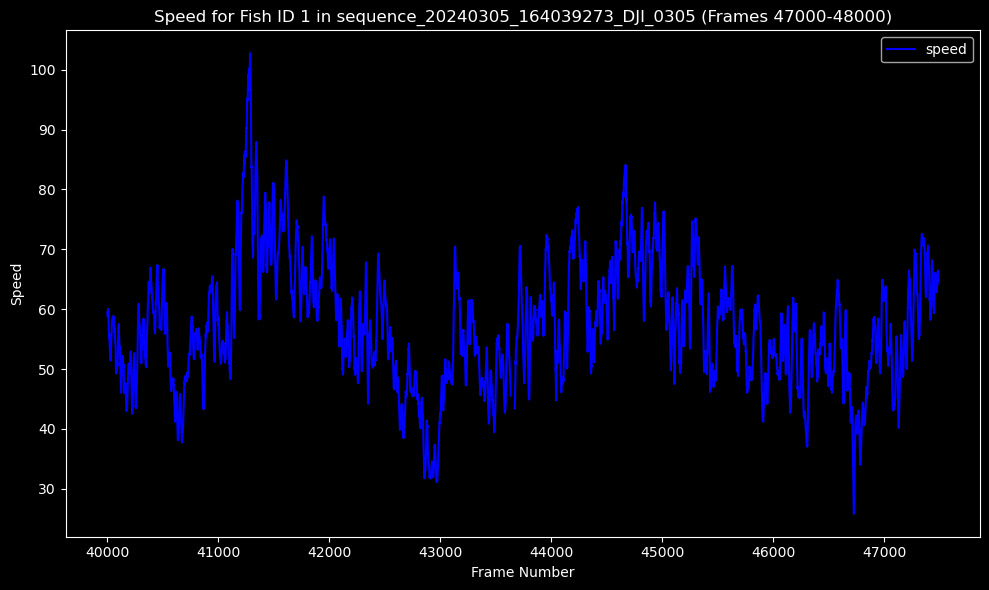

In [12]:
# Define specific trial and fish ID
fish_id = 1  
trial = 'sequence_20240305_164039273_DJI_0305'

# Filter the data for the specified trial and fish ID
filtered_data = df_speed[(df_speed['Trial'] == trial) & (df_speed['ID'] == fish_id)]

# Extract frames and frequencies in the range 47000 to 48000
frame_range = (filtered_data['frame'] >= 40000) & (filtered_data['frame'] <= 47500)
frames = filtered_data['frame'][frame_range]
frequencies = filtered_data['speed'][frame_range]

# Plot the tailbeat frequency for the filtered data
plt.figure(figsize=(10, 6))
plt.plot(frames, frequencies, label="speed", color="b")
plt.xlabel("Frame Number")
plt.ylabel("Speed")
plt.title(f"Speed for Fish ID {fish_id} in {trial} (Frames 47000-48000)")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import pandas as pd

def calculate_body_length(df):
    """
    Calculates the smoothed body length using the distances between key points over frames.
    Handles missing frames by interpolating before smoothing.
    Displays progress every 10,000 frames per trial.
    """
    body_lengths = []
    frame_count = 0  # Counter for progress tracking

    # Group by Trial, ID, and frame
    for (Trial, ID, frame), frame_data in df.groupby(['Trial', 'ID', 'frame']):
        frame_count += 1

        # Display progress every 10,000 frames per trial
        if frame_count % 10000 == 0:
            print(f"Processing: Trial={Trial}, ID={ID}, Frame={frame_count}...")

        try:
            # Extract the coordinates for multiple key points
            p1 = frame_data[['headx', 'heady']].values[0]  
            p2 = frame_data[['btipx', 'btipy']].values[0] 
            p3 = frame_data[['pelvicfinx', 'pelvicfiny']].values[0]  
            p4 = frame_data[['sdfinx', 'sdfiny']].values[0] 
            p5 = frame_data[['pedunclex', 'peduncley']].values[0]  
            p6 = frame_data[['finx', 'finy']].values[0]  
            p7 = frame_data[['ttipx', 'ttipy']].values[0]  
        
            # Calculate the Euclidean distances between consecutive key points
            dist1 = np.linalg.norm(p1 - p2)  
            dist2 = np.linalg.norm(p2 - p3)  
            dist3 = np.linalg.norm(p3 - p4)  
            dist4 = np.linalg.norm(p4 - p5) 
            dist5 = np.linalg.norm(p5 - p6)
            dist6 = np.linalg.norm(p6 - p7) 
            
            # Total length for this frame
            total_length = dist1 + dist2 + dist3 + dist4 + dist5 + dist6
            body_lengths.append((Trial, ID, frame, total_length))
        except Exception as e:
            print(f"Error in processing frame {frame} for Trial {Trial}, ID {ID}: {e}")

    # Convert to DataFrame
    body_length_df = pd.DataFrame(body_lengths, columns=['Trial', 'ID', 'frame', 'body_length'])

    # Sort before interpolation
    body_length_df = body_length_df.sort_values(by=['Trial', 'ID', 'frame']).reset_index(drop=True)
    print("Body length calculation completed.")

    # Fill missing frames by reindexing to include gaps
    def fill_missing_frames(group):
        full_index = range(group['frame'].min(), group['frame'].max() + 1)
        return group.set_index('frame').reindex(full_index).reset_index()

    body_length_df = body_length_df.groupby(['Trial', 'ID'], group_keys=False).apply(fill_missing_frames)

    # Interpolate missing body length values
    body_length_df['body_length'] = body_length_df.groupby(['Trial', 'ID'])['body_length'].transform(
        lambda x: x.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    )

    # Apply smoothing with rolling mean
    body_length_df['smoothed_body_length'] = body_length_df.groupby(['Trial', 'ID'])['body_length'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    print("Smoothed body length calculation completed.")
    return body_length_df[['Trial', 'ID', 'frame', 'smoothed_body_length']]

    
def standardize_speed(df, body_length_df):
    """
    Standardizes the speed of animals based on their smoothed body length.
    """
    # Merge smoothed body length back to the main dataframe
    df_speed = df.merge(body_length_df, on=['Trial', 'ID', 'frame'], how='left')

    # Handle division by zero or NaN
    df_speed['standardized_speed'] = df_speed['speed'] / df_speed['smoothed_body_length'].replace(0, np.nan)

    return df_speed

# Run the code
body_length_df = calculate_body_length(df_speed)
df_speed = standardize_speed(df_speed, body_length_df)


Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=0, Frame=10000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=0, Frame=20000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=1, Frame=30000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=1, Frame=40000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=1, Frame=50000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=2, Frame=60000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=2, Frame=70000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=2, Frame=80000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=3, Frame=90000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=3, Frame=100000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=3, Frame=110000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=4, Frame=120000...
Processing: Trial=sequence_20240303_060726300_DJI_0242, ID=4, Frame=13000

C:\Users\sophi\AppData\Local\Temp\ipykernel_24748\168904891.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  body_length_df = body_length_df.groupby(['Trial', 'ID'], group_keys=False).apply(fill_missing_frames)
C:\Users\sophi\AppData\Local\Temp\ipykernel_24748\168904891.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Smoothed body length calculation completed.


In [18]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "lenght_sharks.h5")
body_length_df.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

C:\Users\sophi\AppData\Local\Temp\ipykernel_24748\230106467.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['Trial'], dtype='object')]

  body_length_df.to_hdf(sharks_output_file, key='sharks', mode='w')


Shark data saved to E:/sophia/shark_data/processed_data/lenght_sharks.h5


In [19]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "speed_sharks.h5")
df_speed.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

Shark data saved to E:/sophia/shark_data/processed_data/speed_sharks.h5


#### For new standard speed cauculation

In [30]:
df_lenght = pd.read_hdf(output_folder + "lenght_sharks.h5", key='sharks')
df_lenght.head()

Trial  ID  frame  smoothed_body_length
0  sequence_20240303_060726300_DJI_0242   0      0            177.037783
1  sequence_20240303_060726300_DJI_0242   0      1            177.242417
2  sequence_20240303_060726300_DJI_0242   0      2            177.303479
3  sequence_20240303_060726300_DJI_0242   0      3            177.349350
4  sequence_20240303_060726300_DJI_0242   0      4            177.272744

In [32]:
def standardize_speed(df):
    """
    Standardizes the speed of animals based on their smoothed body length.
    """
    # Merge smoothed body length back to the main dataframe
    #df_speed = df.merge(body_length_df, on=['Trial', 'ID', 'frame'], how='left')

    # Handle division by zero or NaN
    df_speed['standardized_speed'] = df_speed['speed'] / df_lenght['smoothed_body_length'].replace(0, np.nan)

    return df_speed

df_speed = standardize_speed(df_speed)

In [33]:
df_speed = pd.merge(df_speed, df_lenght[['Trial', 'ID', 'frame', 'smoothed_body_length']], on=['Trial', 'ID', 'frame'], how='left')

In [34]:
df_speed.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   2051        82.087409   0   606.844014  -396.939687 -0.435146   2051   
1   2052        76.964699   0   608.723694  -396.273295 -0.456252   2052   
2   2053        75.903308   0   610.451965  -395.569743 -0.479337   2053   
3   2054        71.775297   0   612.184855  -394.984894 -0.500498   2054   
4   2055        81.043147   0   613.870341  -394.378459 -0.521608   2055   

    time        headx        heady  ...                                 Trial  \
0  40.91  3172.583333  1069.333333  ...  sequence_20240306_161443984_DJI_0139   
1  40.93  3174.333333  1068.916667  ...  sequence_20240306_161443984_DJI_0139   
2  40.95  3175.916667  1068.416667  ...  sequence_20240306_161443984_DJI_0139   
3  40.97  3177.416667  1067.916667  ...  sequence_20240306_161443984_DJI_0139   
4  40.99  3178.833333  1067.500000  ...  sequence_20240306_161443984_DJI_0139   

    midpoint_x   midpoint_y  carangids  drone_movement  ID_checked  \
0  3147.875000  1082.916667          1               0         1.0   
1  3149.708333  1083.125000          1               0         1.0   
2  3151.458333  1083.250000          1               0         1.0   
3  3153.125000  1083.333333          1               0         1.0   
4  3154.750000  1083.416667          1               0         1.0   

   delta_time  speed  standardized_speed  smoothed_body_length  
0         NaN    NaN                 NaN            108.178729  
1         NaN    NaN                 NaN            108.309392  
2         NaN    NaN                 NaN            108.625618  
3         NaN    NaN                 NaN            109.070150  
4         NaN    NaN                 NaN            109.596972  

[5 rows x 39 columns]

### Graphs

In [4]:
df_speed = pd.read_hdf(output_folder + "speed_sharks.h5", key='sharks')
df_speed.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   9677       100.645049   0          NaN          NaN -1.390408   9677   
1   9678       100.709486   0          NaN          NaN -1.412380   9678   
2   9679       104.044606   0          NaN          NaN -1.427205   9679   
3   9680        90.505609   0          NaN          NaN -1.436478   9680   
4   9681        61.877451   0          NaN          NaN -1.438462   9681   

         time        headx  heady  ...                                 Trial  \
0  193.430000  2602.454545    0.0  ...  sequence_20240303_060726300_DJI_0242   
1  193.449999  2601.500000    0.0  ...  sequence_20240303_060726300_DJI_0242   
2  193.470000  2600.888889    0.0  ...  sequence_20240303_060726300_DJI_0242   
3  193.490000  2600.625000    0.0  ...  sequence_20240303_060726300_DJI_0242   
4  193.510000  2600.571429    0.0  ...  sequence_20240303_060726300_DJI_0242   

    midpoint_x  midpoint_y  carangids  drone_movement  ID_checked  delta_time  \
0  2600.818182    8.818182          0               0         1.0         NaN   
1  2600.750000    7.550000          0               0         1.0         NaN   
2  2600.888889    6.888889          0               0         1.0         NaN   
3  2601.125000    6.625000          0               0         1.0         NaN   
4  2601.357143    6.500000          0               0         1.0         NaN   

   speed  smoothed_body_length  standardized_speed  
0    NaN            136.319743                 NaN  
1    NaN            133.552959                 NaN  
2    NaN            130.746758                 NaN  
3    NaN            127.964833                 NaN  
4    NaN            125.257386                 NaN  

[5 rows x 39 columns]

#### Carangid 0-1

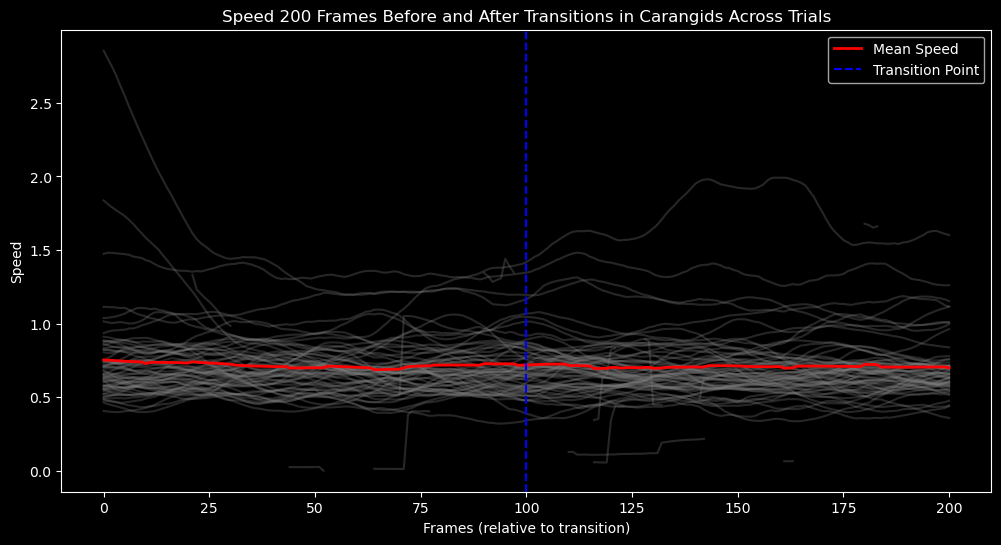

In [5]:
# Ensure the data is sorted by Trial ID and Frame
df = df_speed.sort_values(by=["Trial", "frame", "ID"])

# Store all speed trajectories
all_speeds = []

# Process each Trial separately
for trial_id, trial_data in df.groupby(["Trial","ID",'segment']):
    trial_data = trial_data.reset_index(drop=True)
    
    # Find indices where 'carangids' changes within the Trial
    transition_indices = trial_data.index[(trial_data["carangids"].diff() == 1)].tolist()
    
    # Extract speed data around each transition
    for idx in transition_indices:
        if idx >= 100 and idx + 100 < len(trial_data):  # Ensure valid range
            speed_segment = trial_data.loc[idx - 100: idx + 100, "standardized_speed"].reset_index(drop=True)
            all_speeds.append(speed_segment)

# Convert to DataFrame for easy plotting
speed_df = pd.DataFrame(all_speeds).T
speed_df.columns = [f"Transition_{i}" for i in range(len(all_speeds))]

# Plot the speed around transitions
plt.figure(figsize=(12, 6))
plt.plot(speed_df, alpha=0.3, color='gray')  # Individual transitions
plt.plot(speed_df.mean(axis=1), color='red', linewidth=2, label="Mean Speed")  # Mean trend
plt.axvline(x=100, color='blue', linestyle='--', label="Transition Point")
plt.xlabel("Frames (relative to transition)")
plt.ylabel("Speed")
plt.title("Speed 200 Frames Before and After Transitions in Carangids Across Trials")
plt.legend()
plt.show()

In [31]:
import pandas as pd

# Store results
mean_speeds = {
    "Frames Relative to Transition": list(range(-200, 201)),  # -100 to +100
    "With Transition": [],
    "Without Transition": []
}

# Process each transition and calculate mean speed for all IDs within the transition frame range
for (trial_id, id_value), trial_data in df.groupby(["Trial", "ID"]):
    trial_data = trial_data.reset_index(drop=True)

    # Find transition indices where 'carangids' changes from 0 to 1
    transition_indices = trial_data.index[(trial_data["carangids"].diff() == 1)].tolist()

    for idx in transition_indices:
        if idx >= 200 and idx + 200 < len(trial_data):  # Ensure valid range
            # Extract the 100 frames before and after
            frame_range = trial_data.loc[idx - 200: idx + 200, "frame"].values
            
            # Mean speed for ID with transition
            id_with_transition_data = df[
                (df["Trial"] == trial_id) &
                (df["frame"].isin(frame_range)) &
                (df["ID"] == id_value)
            ].groupby("frame")["standardized_speed"].mean()
            
            # Mean speed for other IDs without transition
            other_ids_data = df[
                (df["Trial"] == trial_id) &
                (df["frame"].isin(frame_range)) &
                (df["ID"] != id_value)
            ].groupby("frame")["standardized_speed"].mean()

            # Store aligned mean speeds
            mean_speeds["With Transition"].append(id_with_transition_data.values)
            mean_speeds["Without Transition"].append(other_ids_data.values)

# Convert lists to DataFrame and compute the final means
meansline_df = pd.DataFrame({
    "Frames Relative to Transition": mean_speeds["Frames Relative to Transition"],
    "With Transition": pd.DataFrame(mean_speeds["With Transition"]).mean(),
    "Without Transition": pd.DataFrame(mean_speeds["Without Transition"]).mean()
})

# Drop NaN values to avoid plotting issues
meansline_df.dropna(inplace=True)

# Display result
print(meansline_df)


     Frames Relative to Transition  With Transition  Without Transition
0                             -200         0.681376            0.699746
1                             -199         0.682704            0.698264
2                             -198         0.683114            0.697806
3                             -197         0.683729            0.697360
4                             -196         0.684981            0.697288
..                             ...              ...                 ...
396                            196         0.693321            0.742600
397                            197         0.693542            0.742631
398                            198         0.693886            0.741095
399                            199         0.694479            0.743670
400                            200         0.694929            0.743836

[401 rows x 3 columns]


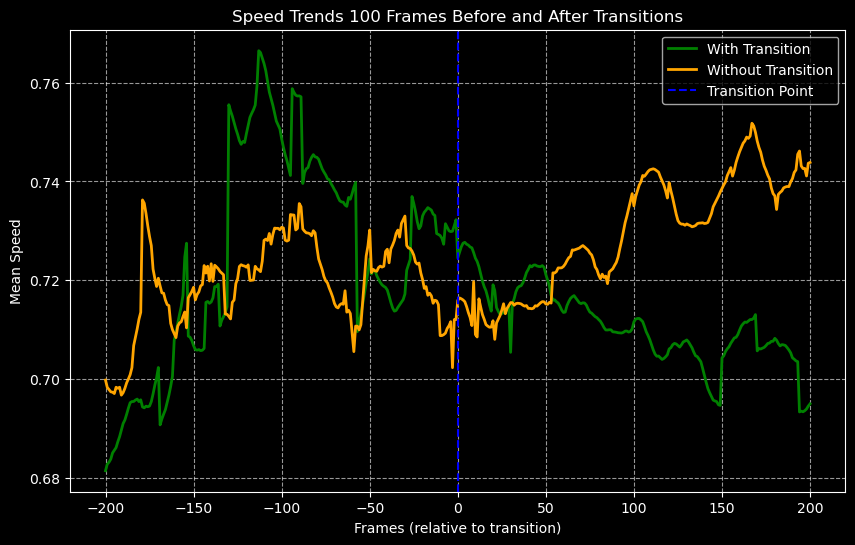

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare DataFrame for plotting
frames_relative = list(range(-200, 201))  # From -100 to +100 frames

# Convert stored lists to DataFrame
speed_df_with_transition = pd.DataFrame(mean_speeds["With Transition"], columns=frames_relative).mean()
speed_df_without_transition = pd.DataFrame(mean_speeds["Without Transition"], columns=frames_relative).mean()

# Plot
plt.figure(figsize=(10, 6))

# Mean speed for IDs with transition
plt.plot(frames_relative, speed_df_with_transition, color='green', linewidth=2, label="With Transition")

# Mean speed for IDs without transition
plt.plot(frames_relative, speed_df_without_transition, color='orange', linewidth=2, label="Without Transition")

# Mark transition frame at x = 0
plt.axvline(x=0, color='blue', linestyle='--', label="Transition Point")

# Labels and title
plt.xlabel("Frames (relative to transition)")
plt.ylabel("Mean Speed")
plt.title("Speed Trends 100 Frames Before and After Transitions")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


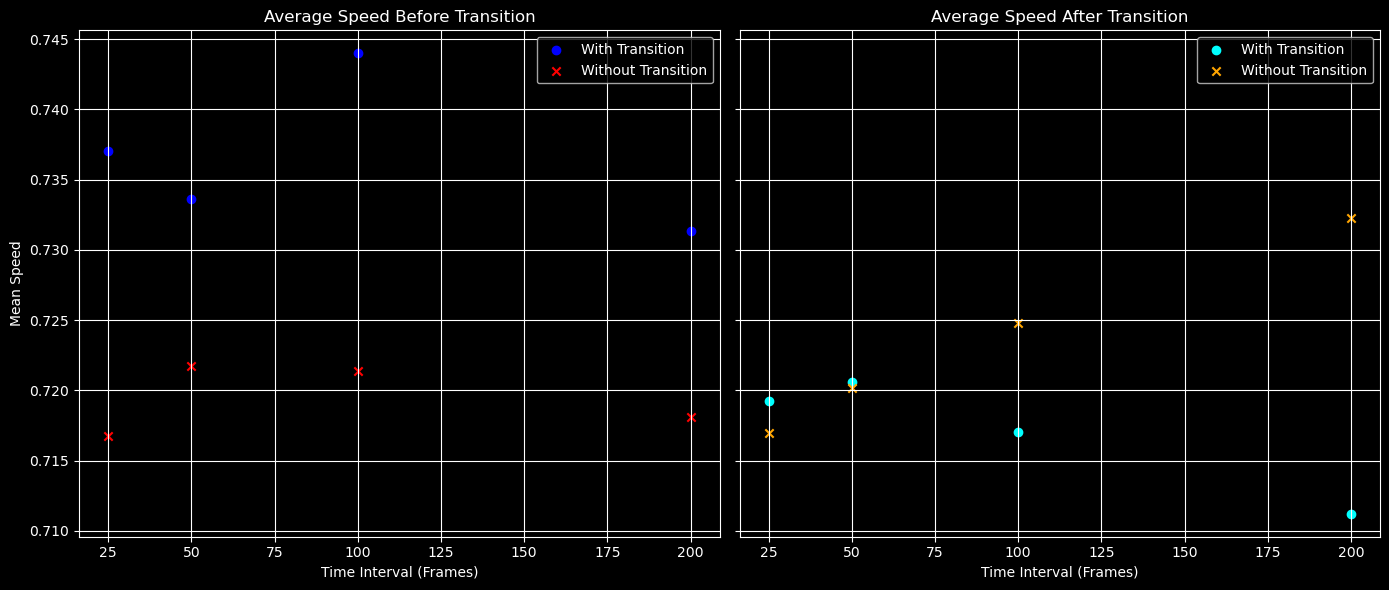

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Store results
mean_speeds_intervals = {
    "Interval (Frames)": [25, 50, 100, 200],  # Time intervals
    "With Transition (Before)": {interval: [] for interval in [25, 50, 100, 200]},
    "With Transition (After)": {interval: [] for interval in [25, 50, 100, 200]},
    "Without Transition (Before)": {interval: [] for interval in [25, 50, 100, 200]},
    "Without Transition (After)": {interval: [] for interval in [25, 50, 100, 200]}
}

# Process each transition and calculate mean speed for the specified intervals
for (trial_id, id_value), trial_data in df.groupby(["Trial", "ID"]):
    trial_data = trial_data.reset_index(drop=True)

    # Find transition indices where 'carangids' changes from 0 to 1
    transition_indices = trial_data.index[(trial_data["carangids"].diff() == 1)].tolist()

    for idx in transition_indices:
        if idx >= 200 and idx + 200 < len(trial_data):  # Ensure valid range
            # Extract the frames before and after the transition for different intervals
            for interval in [25, 50, 100, 200]:
                frame_range_before = trial_data.loc[idx - interval: idx - 1, "frame"].values
                frame_range_after = trial_data.loc[idx: idx + interval - 1, "frame"].values

                # Mean speed for ID with transition (Before and After)
                id_with_transition_data_before = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_before)) &
                    (df["ID"] == id_value)
                ]["standardized_speed"].mean()

                id_with_transition_data_after = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_after)) &
                    (df["ID"] == id_value)
                ]["standardized_speed"].mean()

                # Mean speed for other IDs without transition (Before and After)
                other_ids_data_before = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_before)) &
                    (df["ID"] != id_value)
                ]["standardized_speed"].mean()

                other_ids_data_after = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_after)) &
                    (df["ID"] != id_value)
                ]["standardized_speed"].mean()

                # Store data
                mean_speeds_intervals["With Transition (Before)"][interval].append(id_with_transition_data_before)
                mean_speeds_intervals["With Transition (After)"][interval].append(id_with_transition_data_after)
                mean_speeds_intervals["Without Transition (Before)"][interval].append(other_ids_data_before)
                mean_speeds_intervals["Without Transition (After)"][interval].append(other_ids_data_after)

# Compute the final mean across all trials and transitions for each interval
final_means = {
    "Interval (Frames)": [25, 50, 100, 200],
    "With Transition (Before)": [np.nanmean(mean_speeds_intervals["With Transition (Before)"][interval]) for interval in [25, 50, 100, 200]],
    "With Transition (After)": [np.nanmean(mean_speeds_intervals["With Transition (After)"][interval]) for interval in [25, 50, 100, 200]],
    "Without Transition (Before)": [np.nanmean(mean_speeds_intervals["Without Transition (Before)"][interval]) for interval in [25, 50, 100, 200]],
    "Without Transition (After)": [np.nanmean(mean_speeds_intervals["Without Transition (After)"][interval]) for interval in [25, 50, 100, 200]]
}

# Convert dictionary to DataFrame
mean_speeds_df = pd.DataFrame(final_means)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- First Plot: Before Transition ---
axes[0].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["With Transition (Before)"], color="blue", label="With Transition", marker="o")
axes[0].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["Without Transition (Before)"], color="red", label="Without Transition", marker="x")

axes[0].set_xlabel("Time Interval (Frames)")
axes[0].set_ylabel("Mean Speed")
axes[0].set_title("Average Speed Before Transition")
axes[0].legend()
axes[0].grid(True)

# --- Second Plot: After Transition ---
axes[1].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["With Transition (After)"], color="cyan", label="With Transition", marker="o")
axes[1].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["Without Transition (After)"], color="orange", label="Without Transition", marker="x")

axes[1].set_xlabel("Time Interval (Frames)")
axes[1].set_title("Average Speed After Transition")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


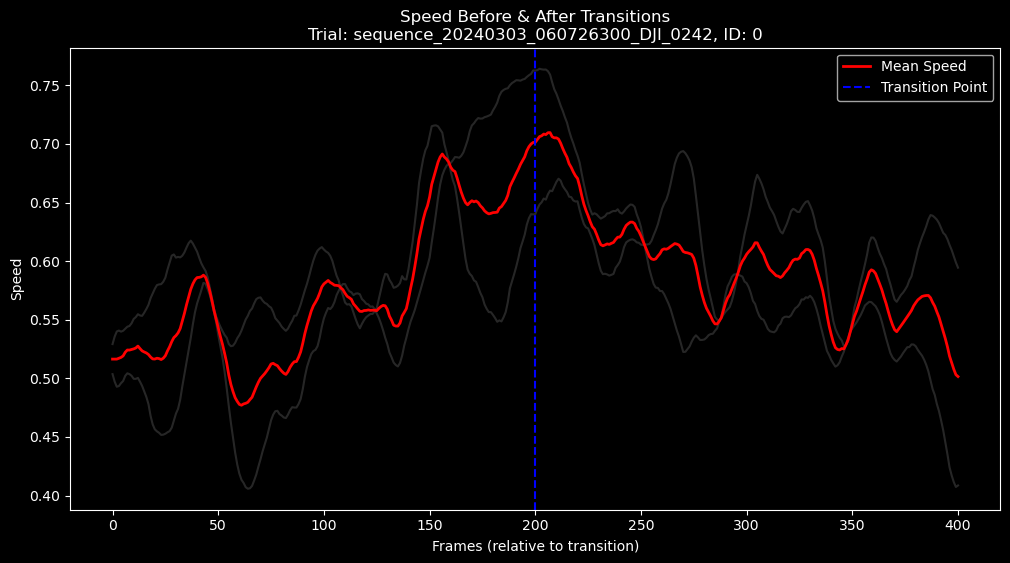

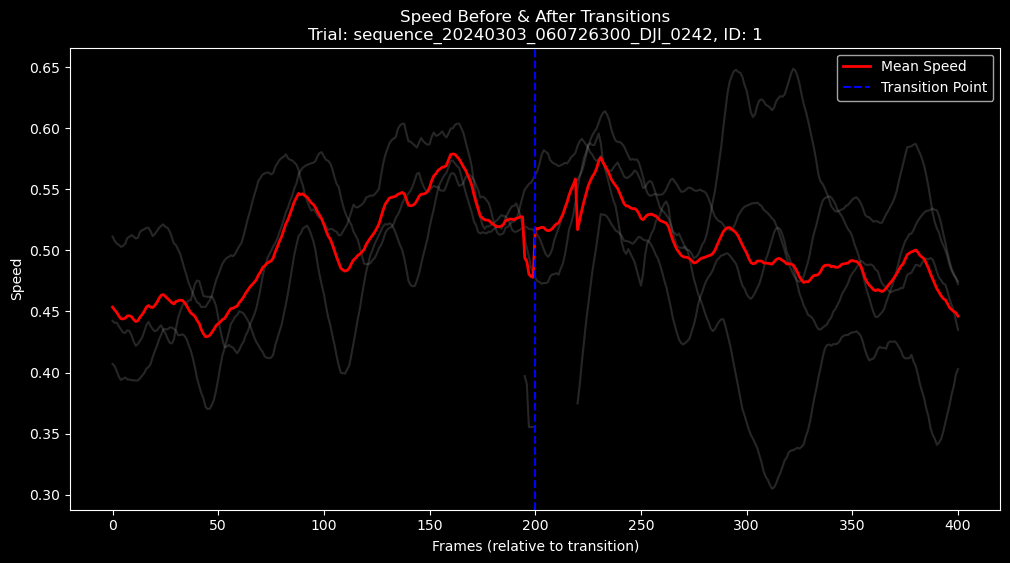

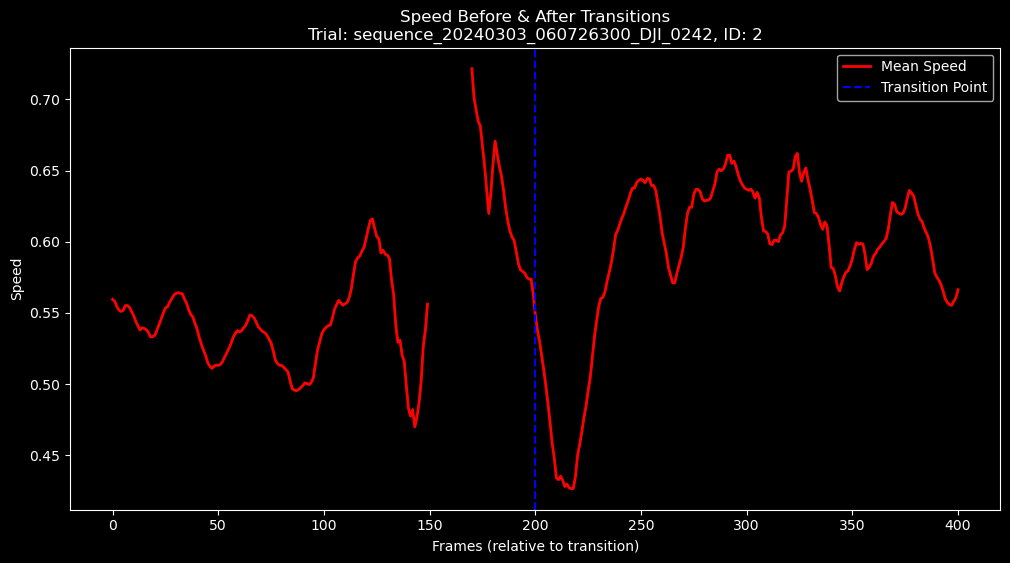

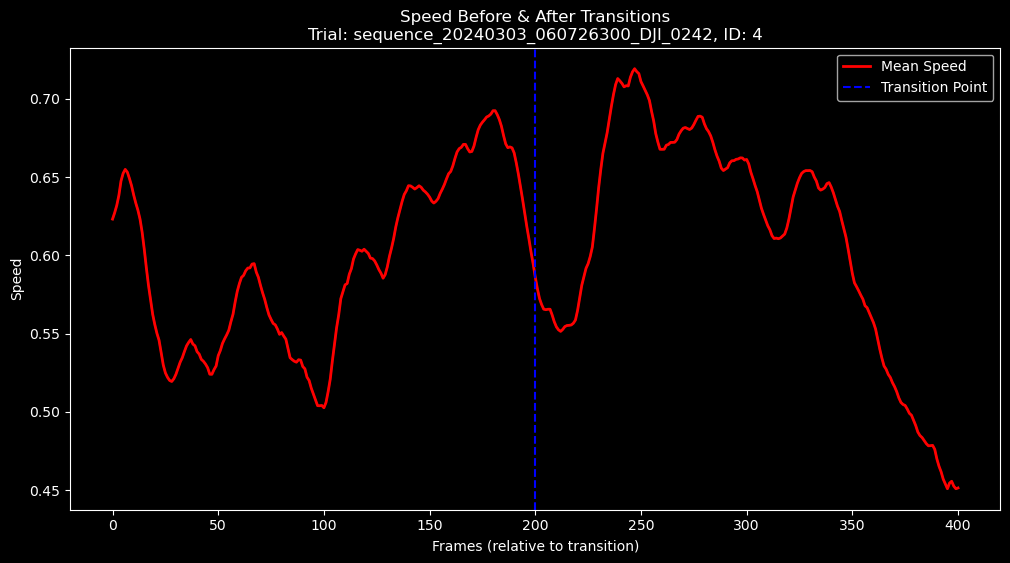

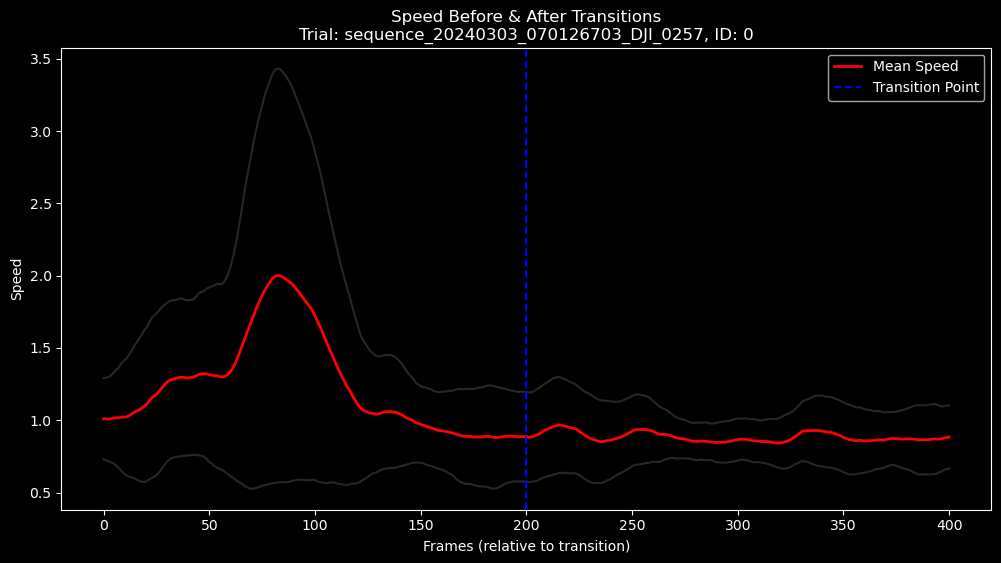

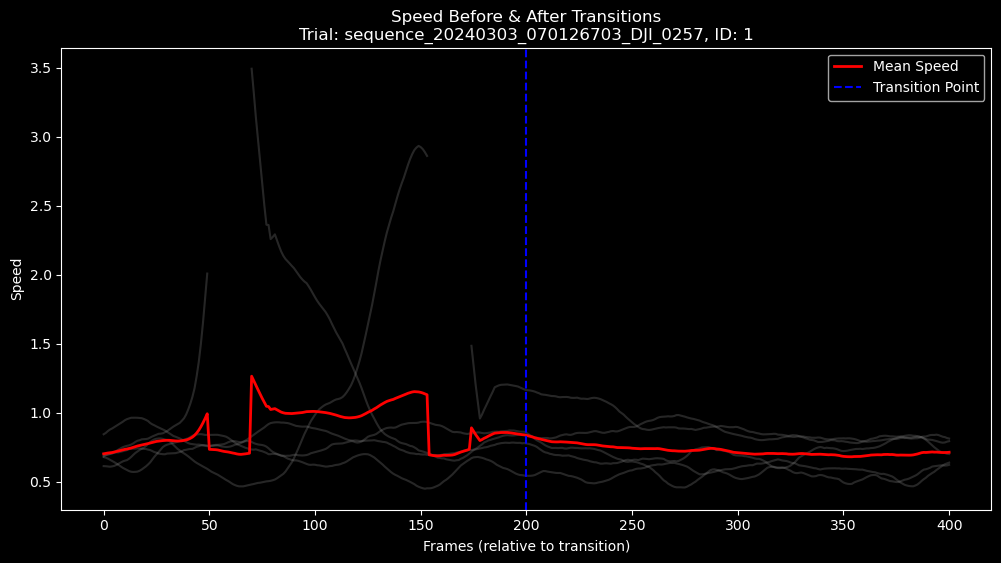

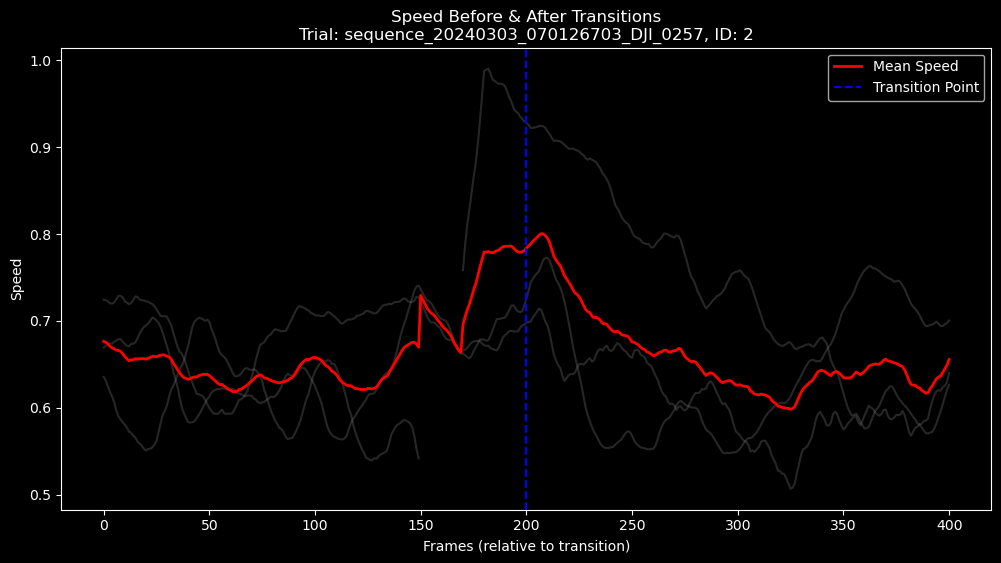

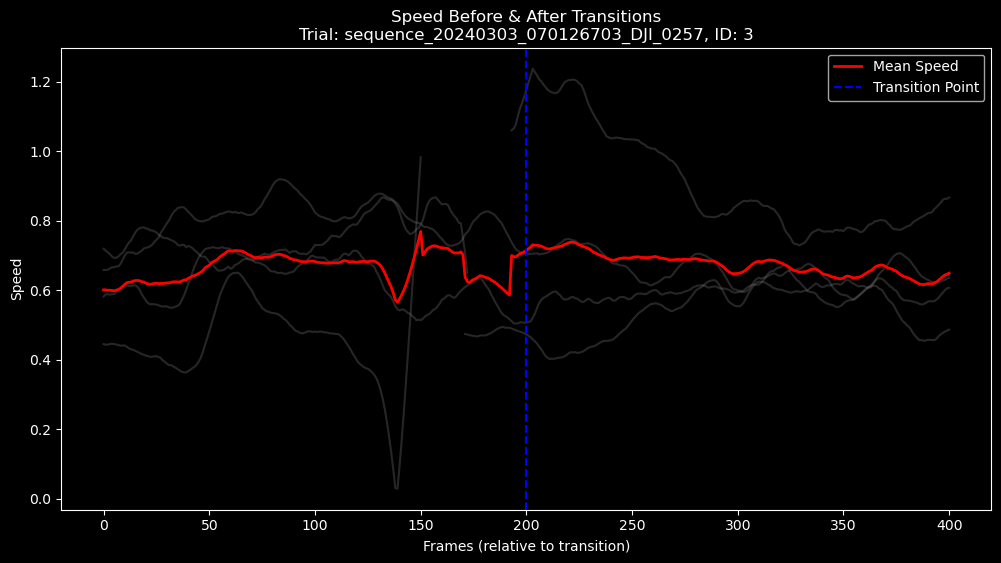

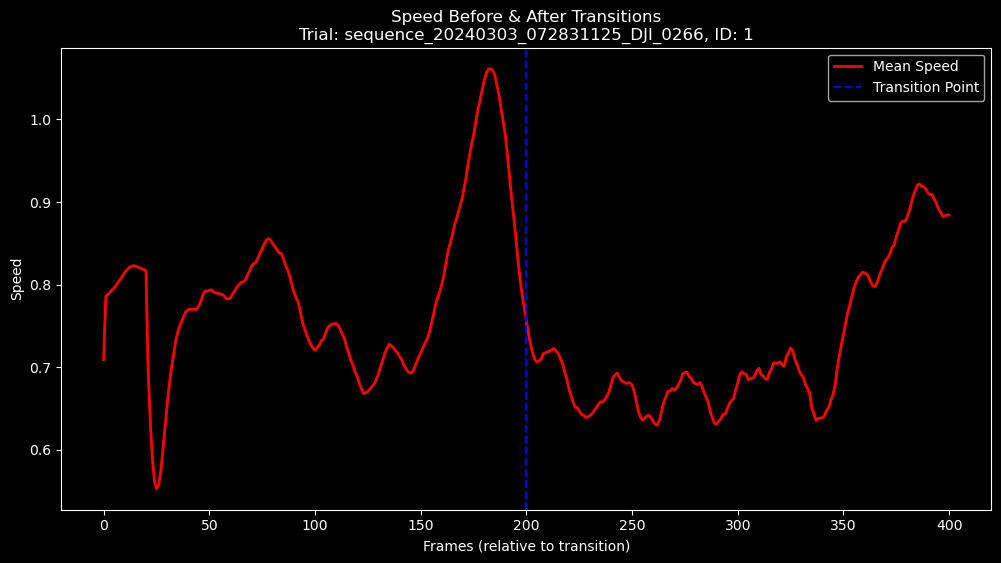

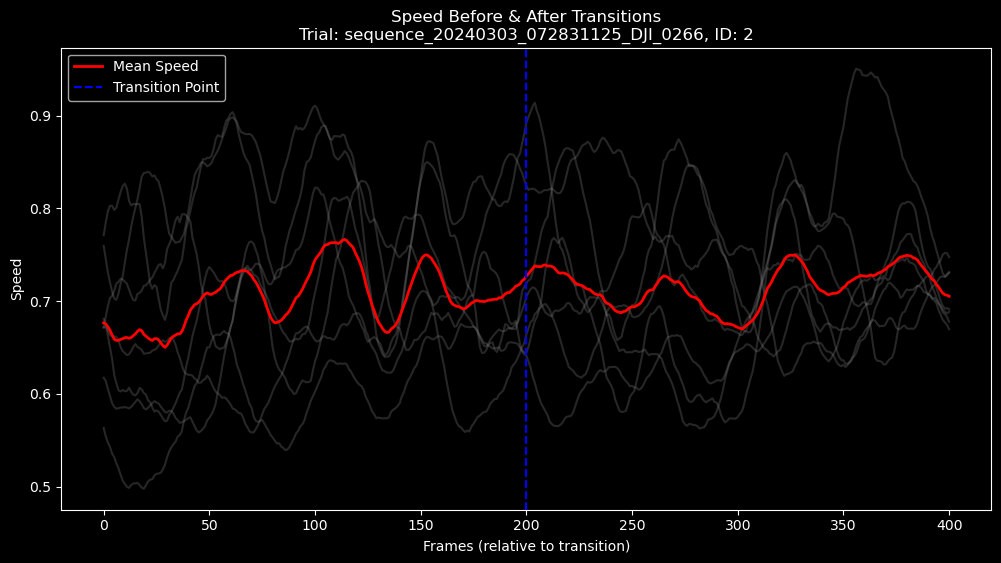

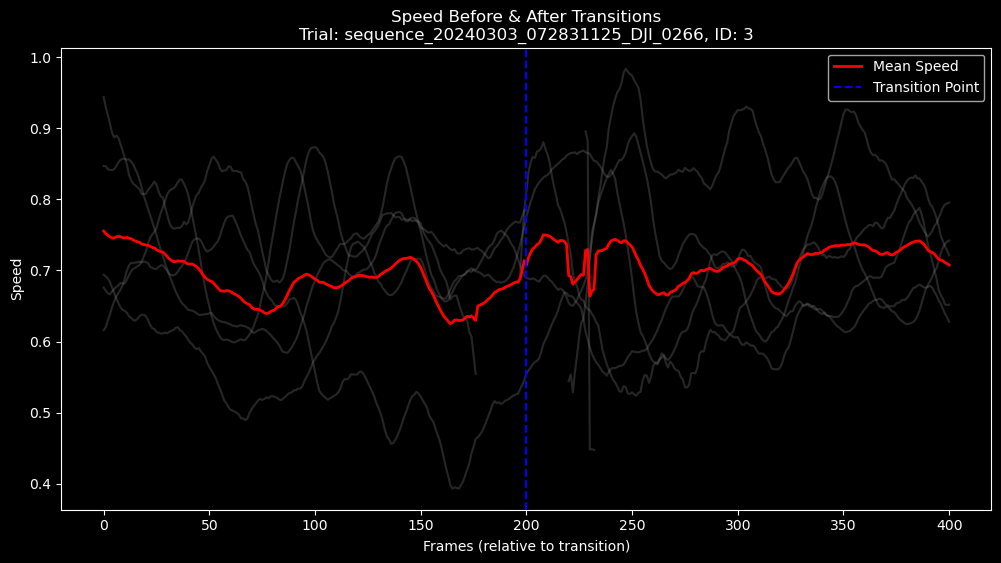

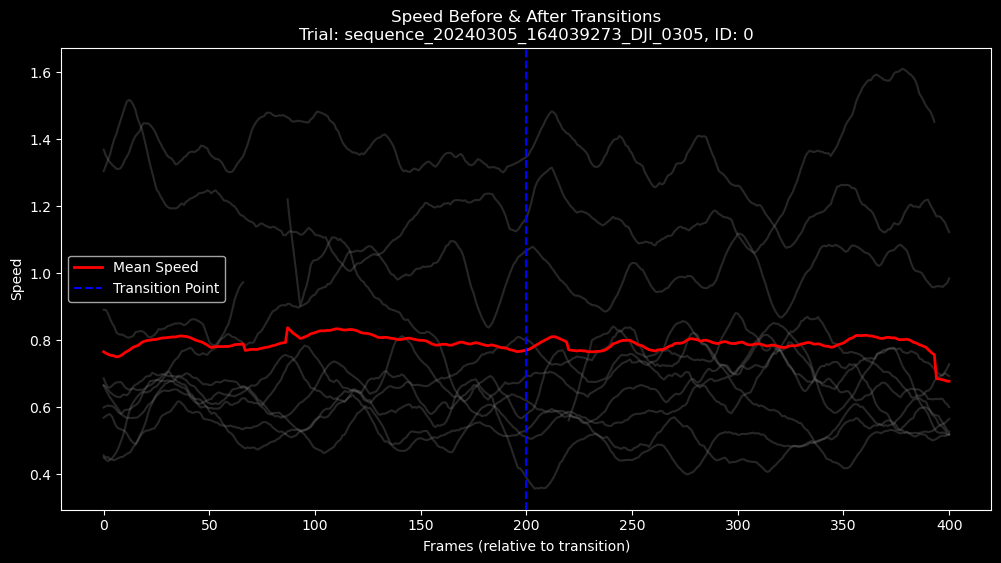

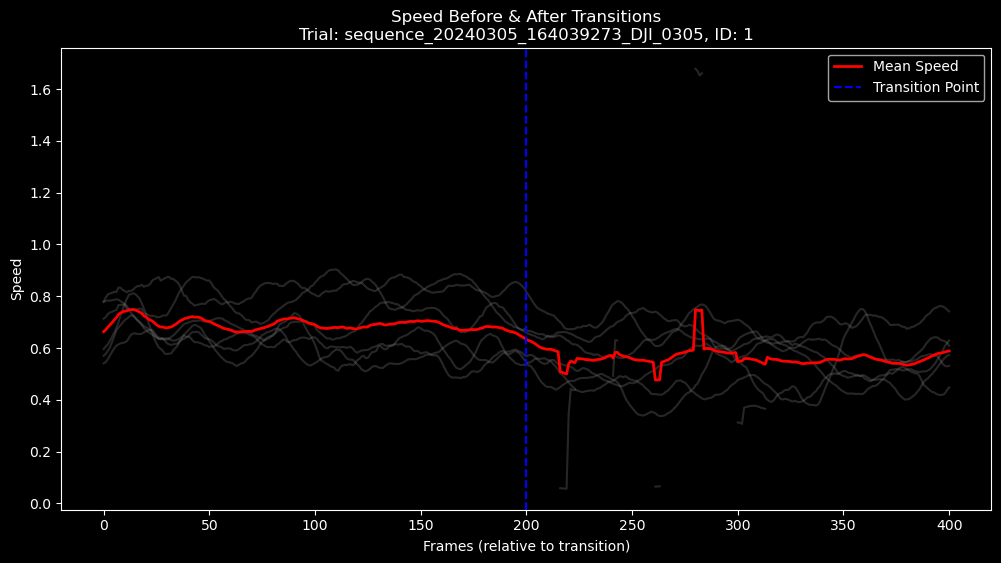

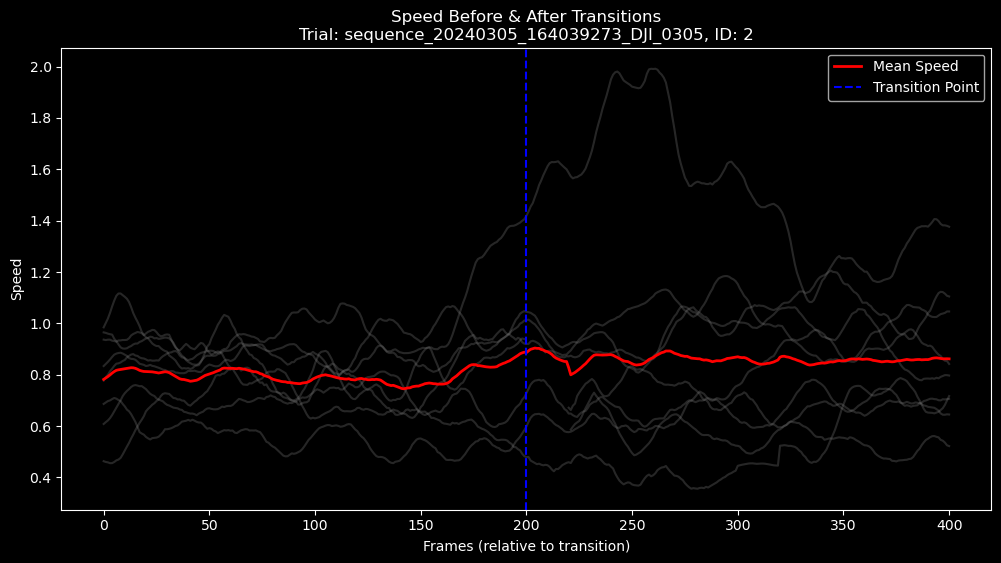

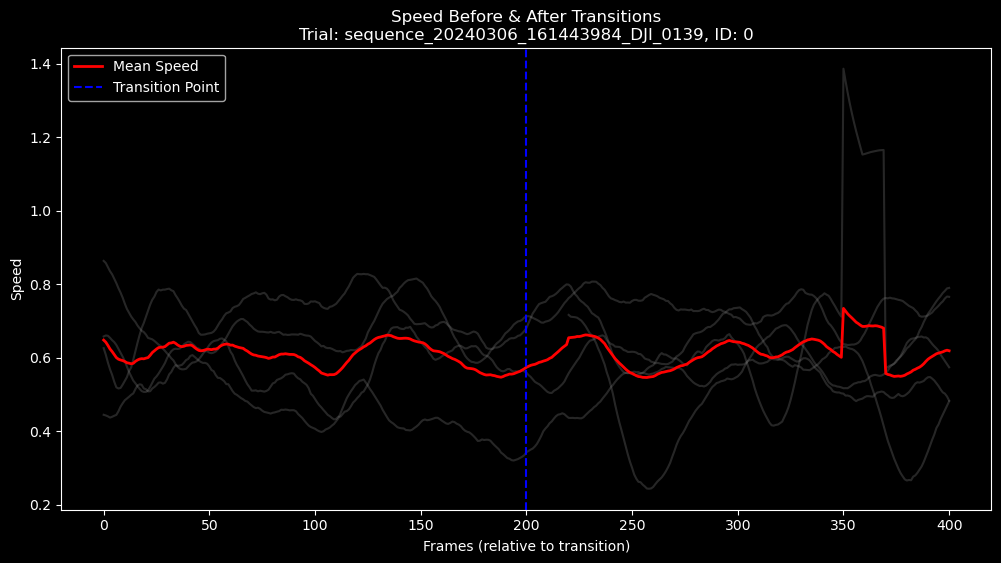

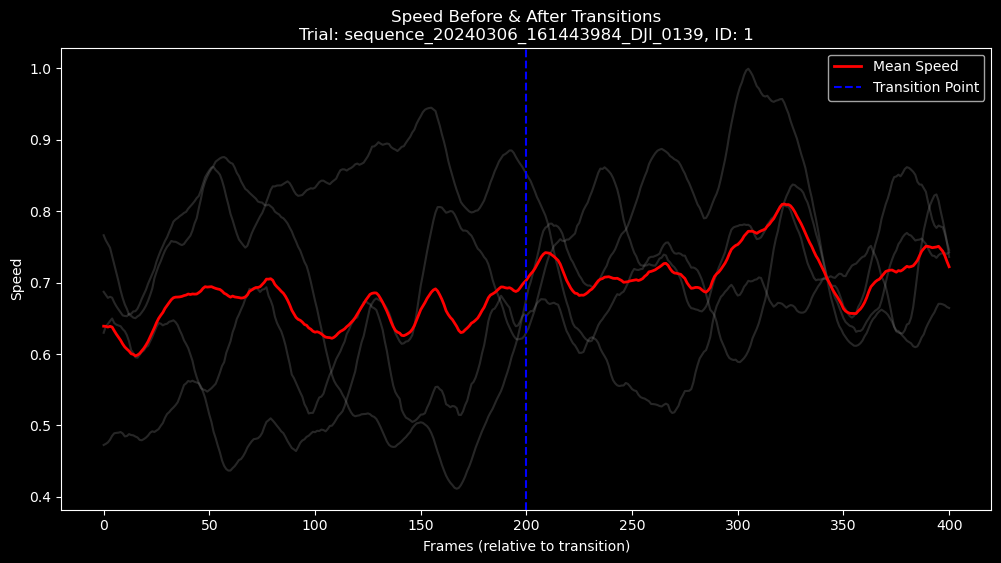

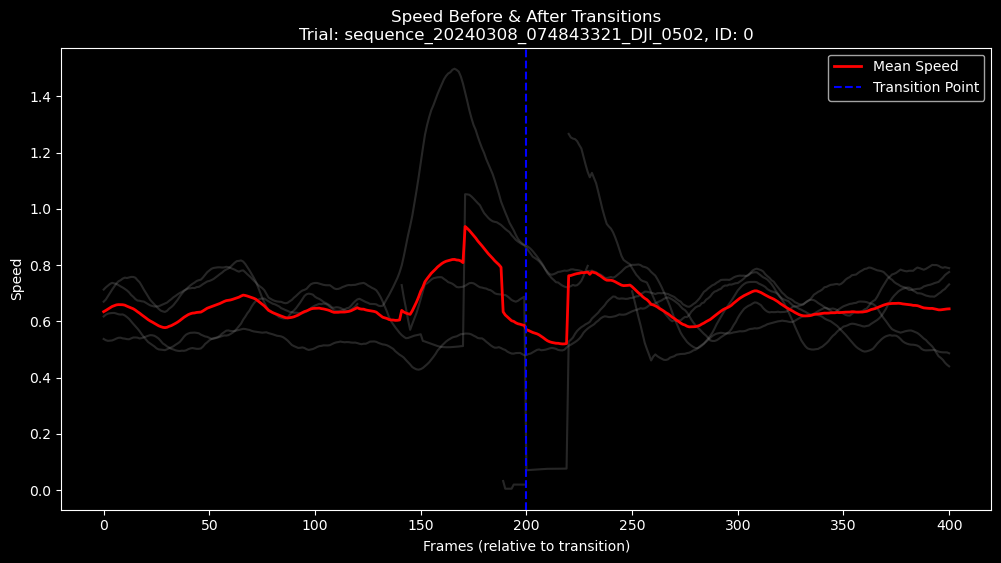

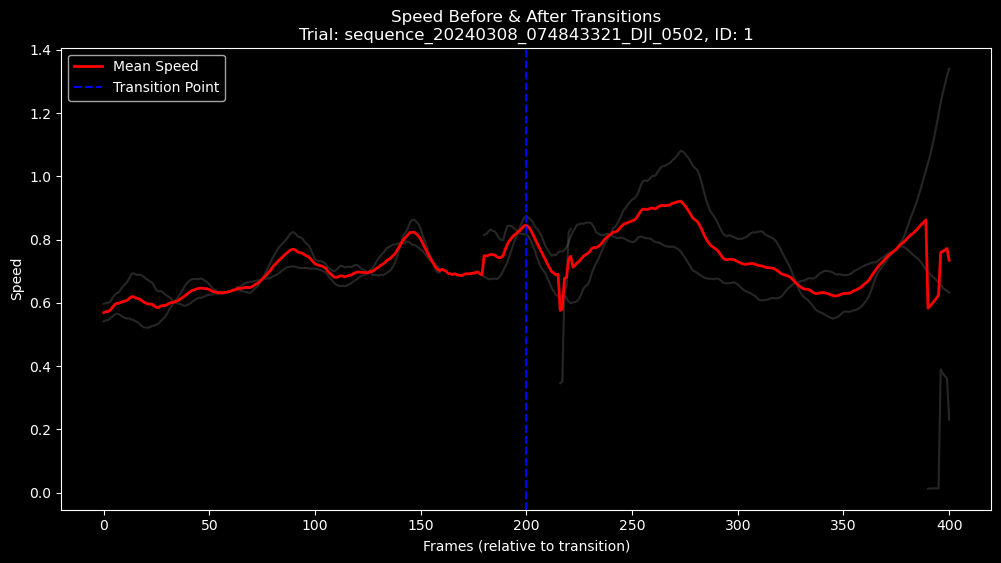

In [8]:

# Process each (Trial, ID) combination separately
for (trial_id, fish_id), group_data in df_speed.groupby(["Trial", "ID"]):  
    group_data = group_data.reset_index(drop=True)  

    # Find indices where 'carangids' changes from 0 to 1 within the group
    transition_indices = group_data.index[(group_data["carangids"].diff() == 1)].tolist()

    # Skip if no transitions are found
    if not transition_indices:
        continue  

    # Store all speed trajectories for this (Trial, ID)
    all_speeds = []

    # Extract speed data around each transition
    for idx in transition_indices:
        if idx >= 200 and idx + 200 < len(group_data):  # Ensure valid range
            speed_segment = group_data.loc[idx - 200: idx + 200, "standardized_speed"].reset_index(drop=True)
            all_speeds.append(speed_segment)

    # If no valid transitions remain, skip plotting
    if not all_speeds:
        continue  

    # Convert to DataFrame for easy plotting
    speed_df = pd.DataFrame(all_speeds).T
    speed_df.columns = [f"Transition_{i}" for i in range(len(all_speeds))]

    # Check if there is actual data to plot (avoid empty plots)
    if speed_df.shape[1] == 0:
        continue  

    # Plot the speed around transitions for this (Trial, ID)
    plt.figure(figsize=(12, 6))
    plt.plot(speed_df, alpha=0.3, color='gray')  # Individual transitions
    plt.plot(speed_df.mean(axis=1), color='red', linewidth=2, label="Mean Speed")  # Mean trend
    plt.axvline(x=200, color='blue', linestyle='--', label="Transition Point")
    plt.xlabel("Frames (relative to transition)")
    plt.ylabel("Speed")
    plt.title(f"Speed Before & After Transitions\nTrial: {trial_id}, ID: {fish_id}")
    plt.legend()
    plt.show()


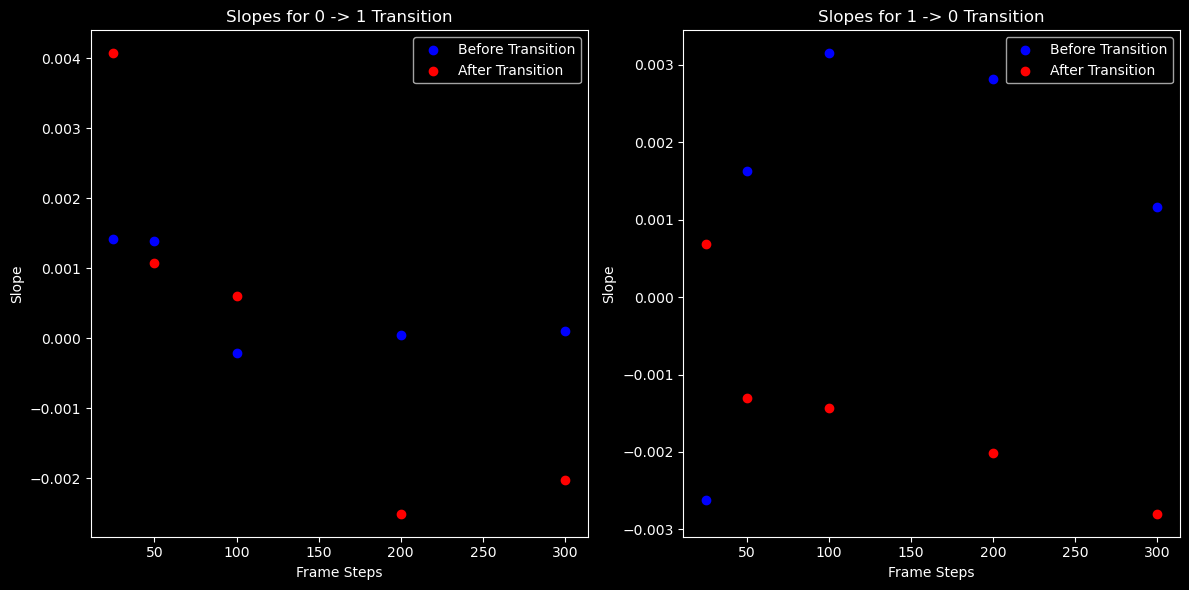

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Ensure the data is sorted by Trial ID and Frame
df = df_speed.sort_values(by=["Trial", "frame", "ID"])

# Define frame intervals to analyze
frame_intervals = [25, 50, 100, 200, 300]

# Initialize dictionary to store slopes
slopes = {
    "0_to_1": {f"before_{n}": [] for n in frame_intervals} | {f"after_{n}": [] for n in frame_intervals},
    "1_to_0": {f"before_{n}": [] for n in frame_intervals} | {f"after_{n}": [] for n in frame_intervals}
}

# Process each Trial separately
for trial_id, trial_data in df.groupby(["Trial", "ID", "segment"]):
    trial_data = trial_data.reset_index(drop=True)
    
    # Find indices where 'carangids' changes
    transition_0_to_1 = trial_data.index[(trial_data["carangids"].diff() == 1)].tolist()
    transition_1_to_0 = trial_data.index[(trial_data["carangids"].diff() == -1)].tolist()
    
    # Function to compute slopes for given transitions
    def compute_slopes(transition_indices, transition_type):
        for idx in transition_indices:
            for n in frame_intervals:
                if idx >= n and idx + n < len(trial_data):  # Ensure valid range
                    speed_before = trial_data.loc[idx - n: idx - 1, "standardized_speed"].dropna().reset_index(drop=True)
                    speed_after = trial_data.loc[idx: idx + n, "standardized_speed"].dropna().reset_index(drop=True)

                    time_before = np.arange(-n, 0).reshape(-1, 1)[:len(speed_before)]
                    time_after = np.arange(0, n + 1).reshape(-1, 1)[:len(speed_after)]

                    if len(speed_before) > 1:
                        model_before = LinearRegression()
                        model_before.fit(time_before, speed_before)
                        slopes[transition_type][f"before_{n}"].append(model_before.coef_[0])

                    if len(speed_after) > 1:
                        model_after = LinearRegression()
                        model_after.fit(time_after, speed_after)
                        slopes[transition_type][f"after_{n}"].append(model_after.coef_[0])

    # Compute slopes for both transition types
    compute_slopes(transition_0_to_1, "0_to_1")
    compute_slopes(transition_1_to_0, "1_to_0")

# Compute average slopes
average_slopes = {
    transition: {key: np.mean(values) if values else np.nan for key, values in slope_dict.items()}
    for transition, slope_dict in slopes.items()
}

# Plotting the slopes for 0 -> 1 transitions
plt.figure(figsize=(12, 6))

# Plot for "before" slopes (0 -> 1)
plt.subplot(1, 2, 1)
plt.scatter(frame_intervals, [average_slopes["0_to_1"][f"before_{n}"] for n in frame_intervals], marker='o', label="Before Transition", color="blue")
plt.scatter(frame_intervals, [average_slopes["0_to_1"][f"after_{n}"] for n in frame_intervals], marker='o', label="After Transition", color="red")
plt.xlabel("Frame Steps")
plt.ylabel("Slope")
plt.title("Slopes for 0 -> 1 Transition")
plt.legend()

# Plot for "before" slopes (1 -> 0)
plt.subplot(1, 2, 2)
plt.scatter(frame_intervals, [average_slopes["1_to_0"][f"before_{n}"] for n in frame_intervals], marker='o', label="Before Transition", color="blue")
plt.scatter(frame_intervals, [average_slopes["1_to_0"][f"after_{n}"] for n in frame_intervals], marker='o', label="After Transition", color="red")
plt.xlabel("Frame Steps")
plt.ylabel("Slope")
plt.title("Slopes for 1 -> 0 Transition")
plt.legend()

plt.tight_layout()
plt.show()


#### Carangid 1-0

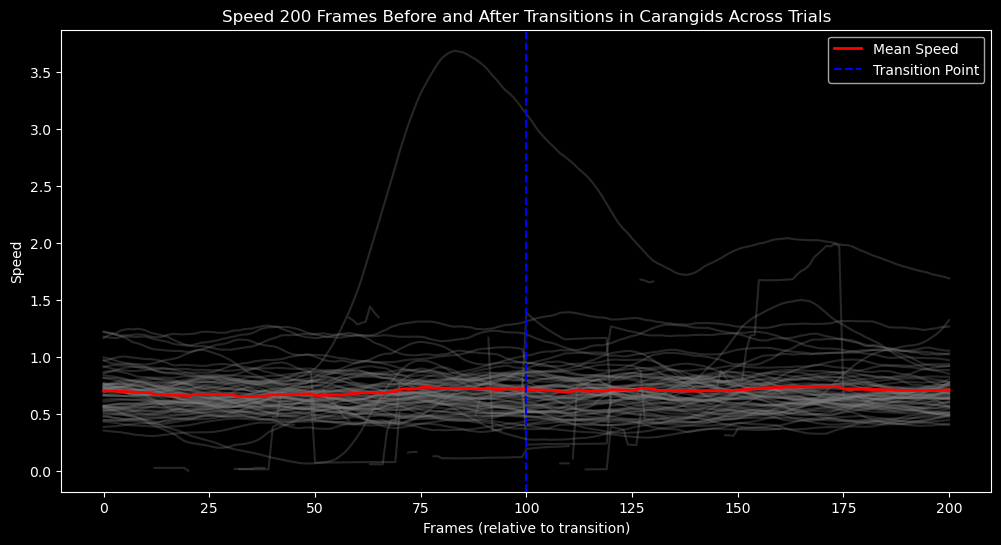

In [8]:
# Ensure the data is sorted by Trial ID and Frame
df = df_speed.sort_values(by=["Trial", "frame", "ID"])

# Store all speed trajectories
all_speeds = []

# Process each Trial separately
for trial_id, trial_data in df.groupby(["Trial","ID",'segment']):
    trial_data = trial_data.reset_index(drop=True)
    
    # Find indices where 'carangids' changes within the Trial
    transition_indices = trial_data.index[(trial_data["carangids"].diff() == -1)].tolist()
    
    # Extract speed data around each transition
    for idx in transition_indices:
        if idx >= 100 and idx + 100 < len(trial_data):  # Ensure valid range
            speed_segment = trial_data.loc[idx - 100: idx + 100, "standardized_speed"].reset_index(drop=True)
            all_speeds.append(speed_segment)

# Convert to DataFrame for easy plotting
speed_df = pd.DataFrame(all_speeds).T
speed_df.columns = [f"Transition_{i}" for i in range(len(all_speeds))]

# Plot the speed around transitions
plt.figure(figsize=(12, 6))
plt.plot(speed_df, alpha=0.3, color='gray')  # Individual transitions
plt.plot(speed_df.mean(axis=1), color='red', linewidth=2, label="Mean Speed")  # Mean trend
plt.axvline(x=100, color='blue', linestyle='--', label="Transition Point")
plt.xlabel("Frames (relative to transition)")
plt.ylabel("Speed")
plt.title("Speed 200 Frames Before and After Transitions in Carangids Across Trials")
plt.legend()
plt.show()

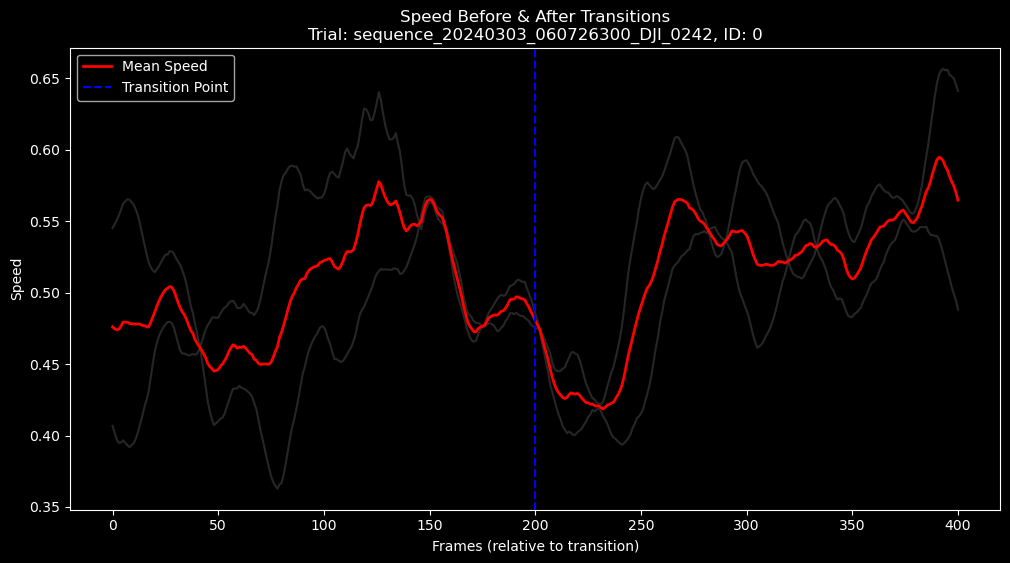

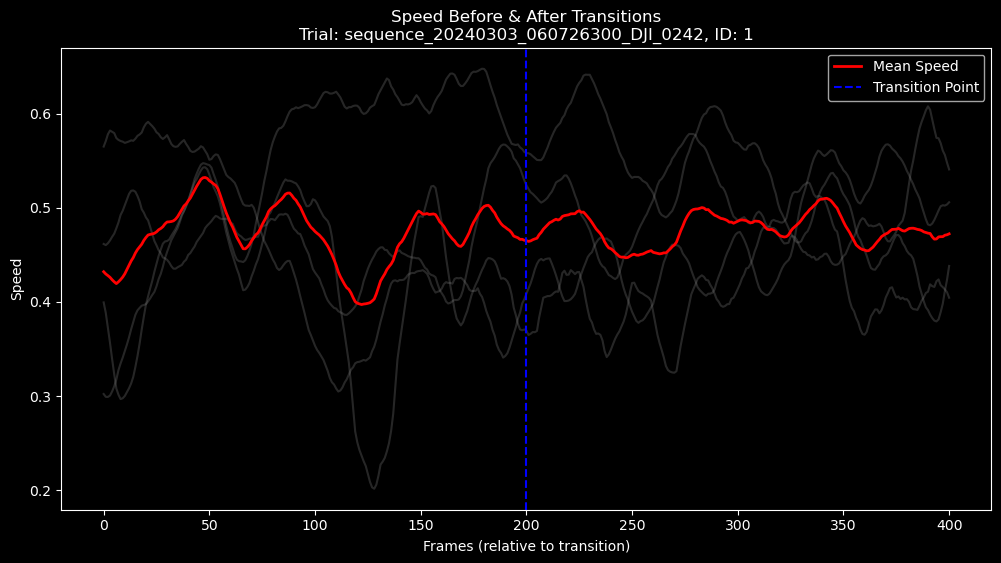

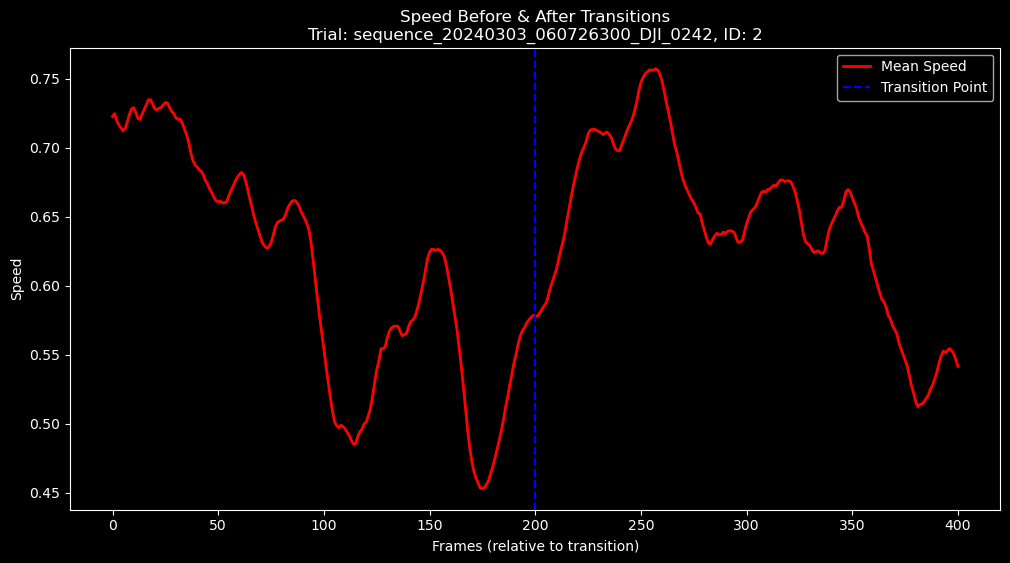

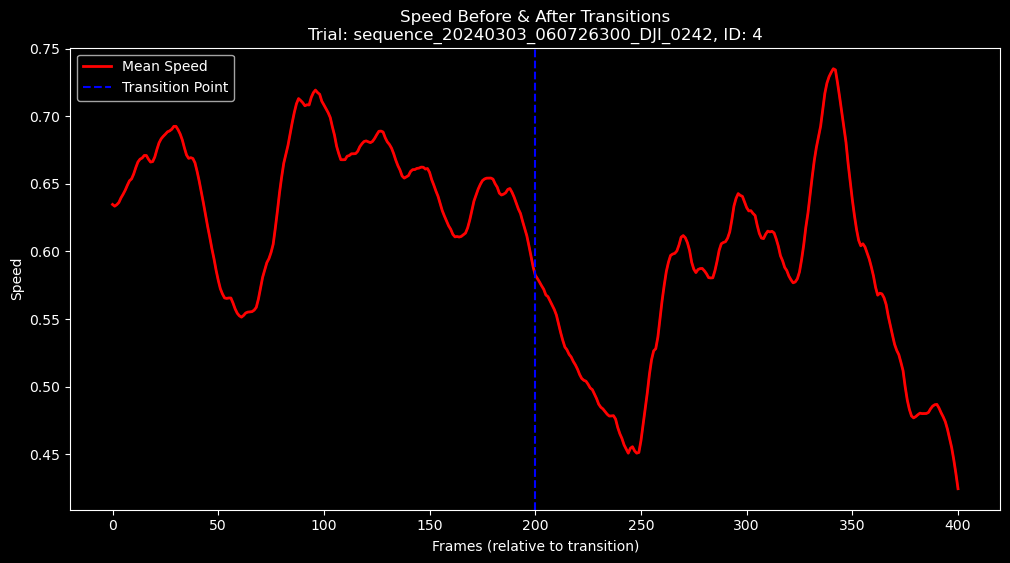

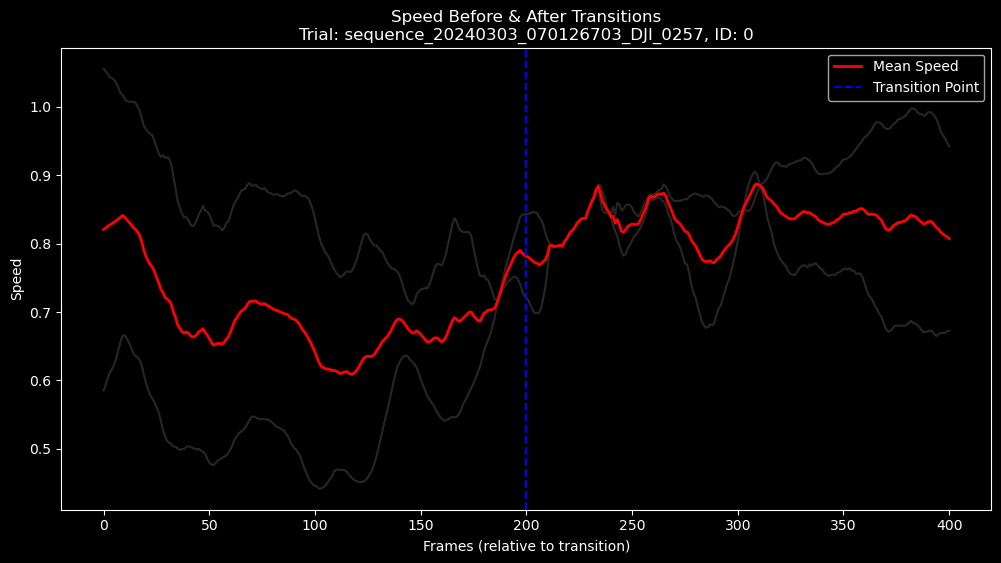

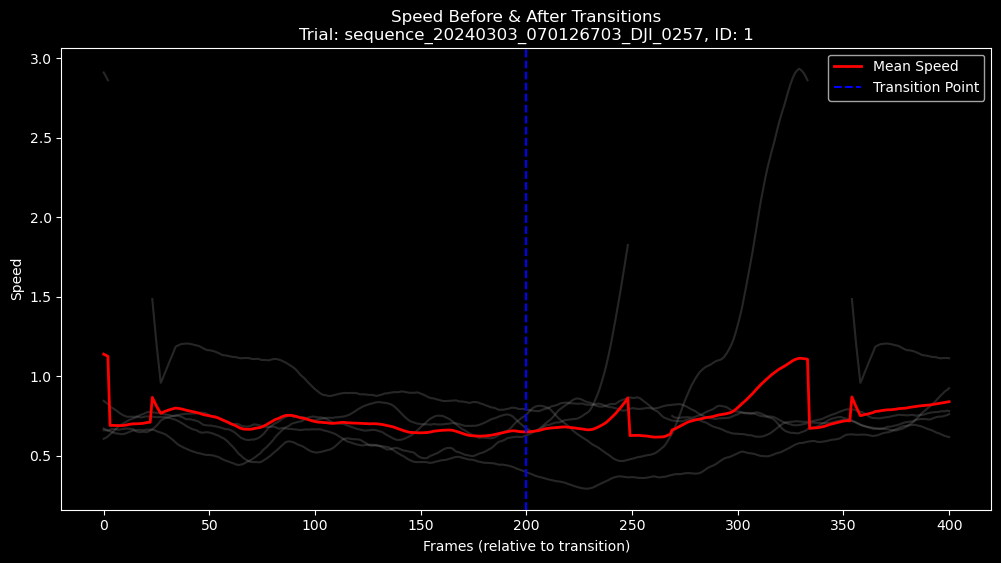

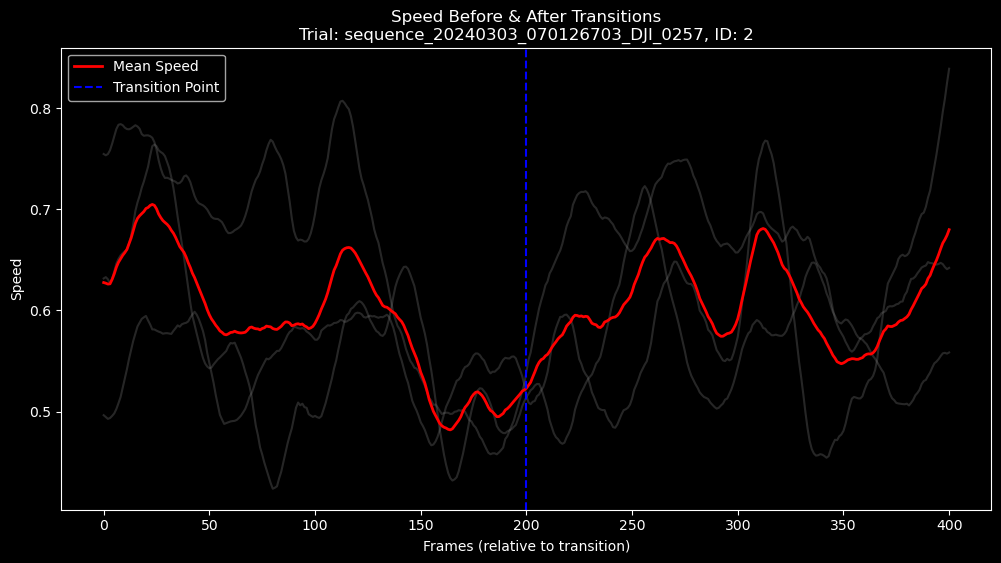

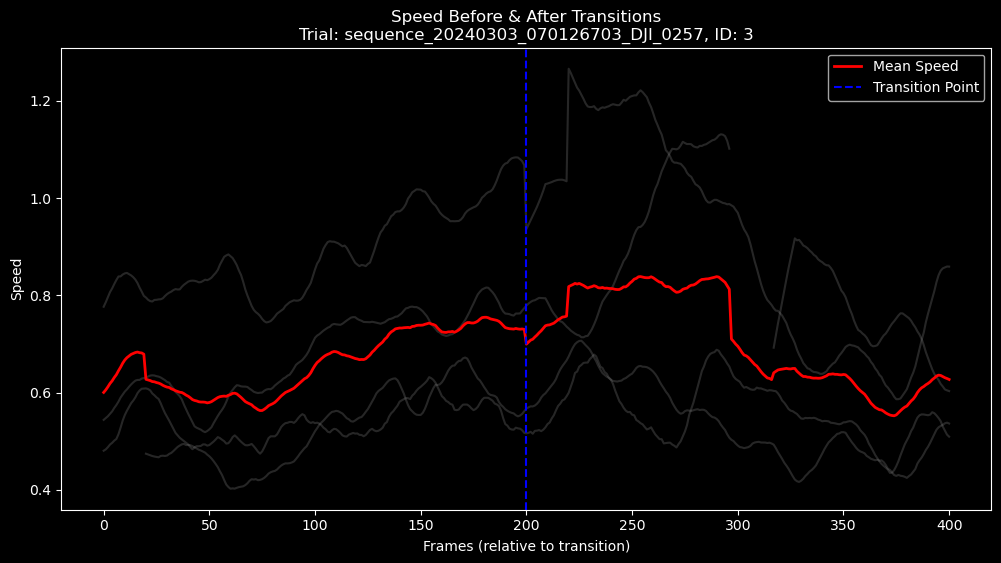

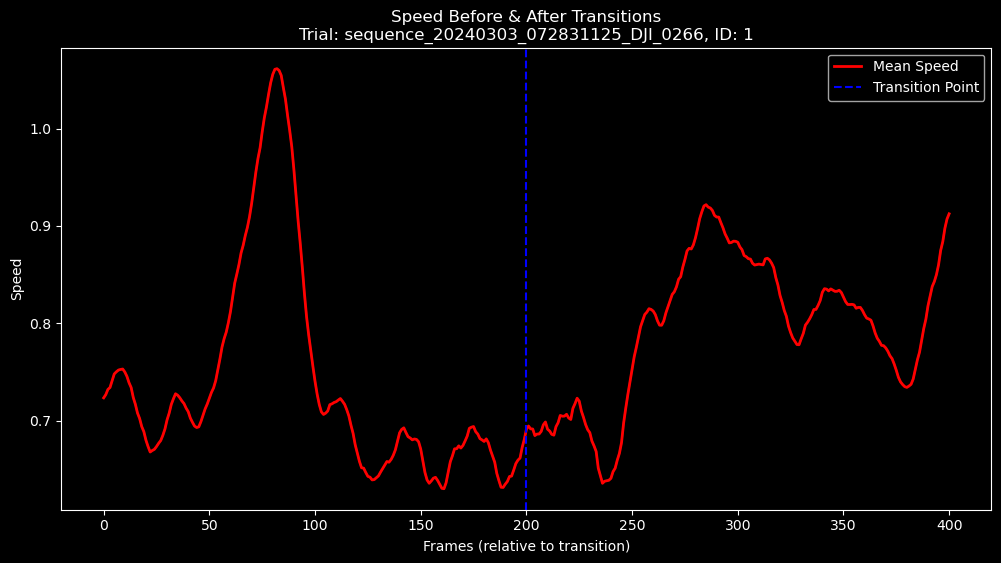

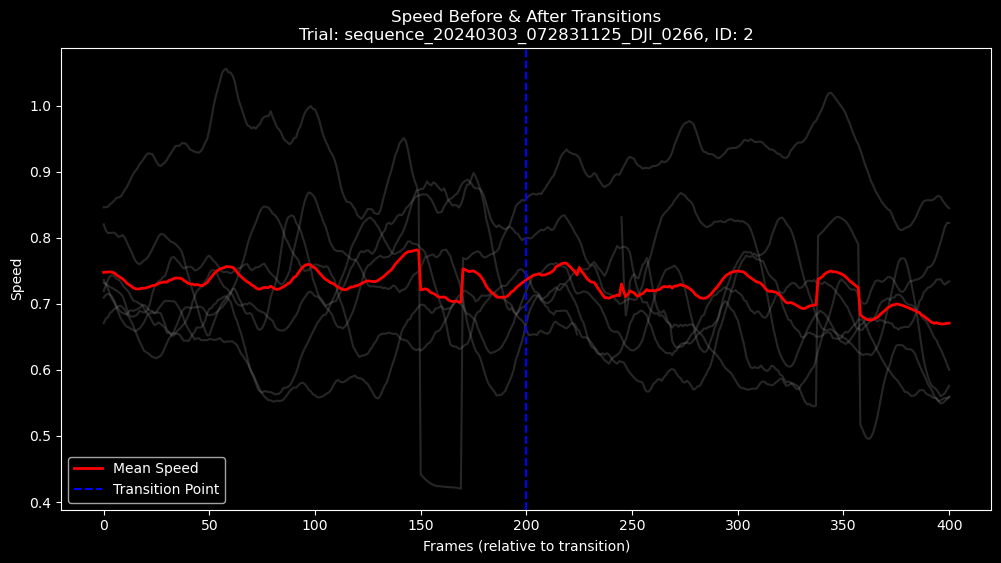

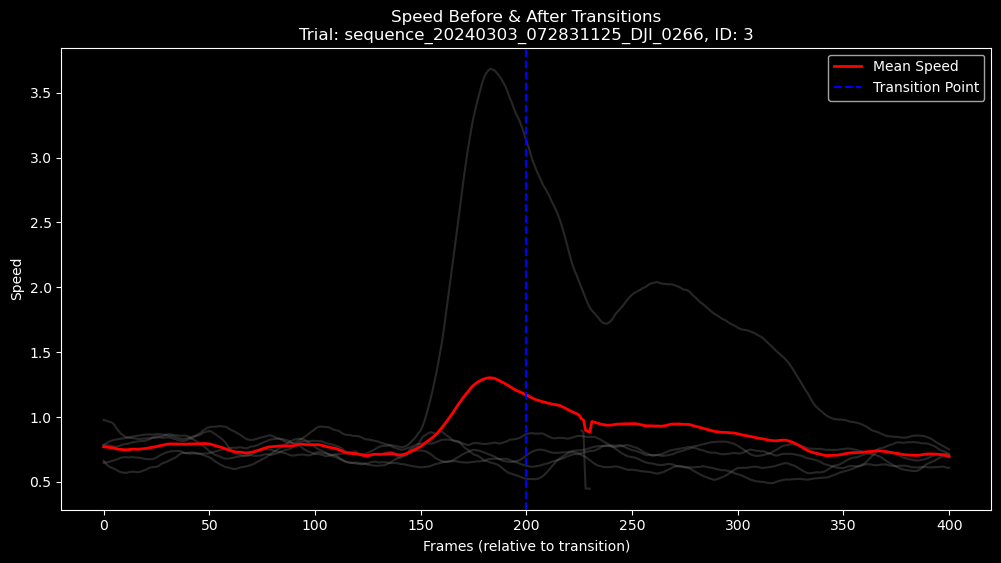

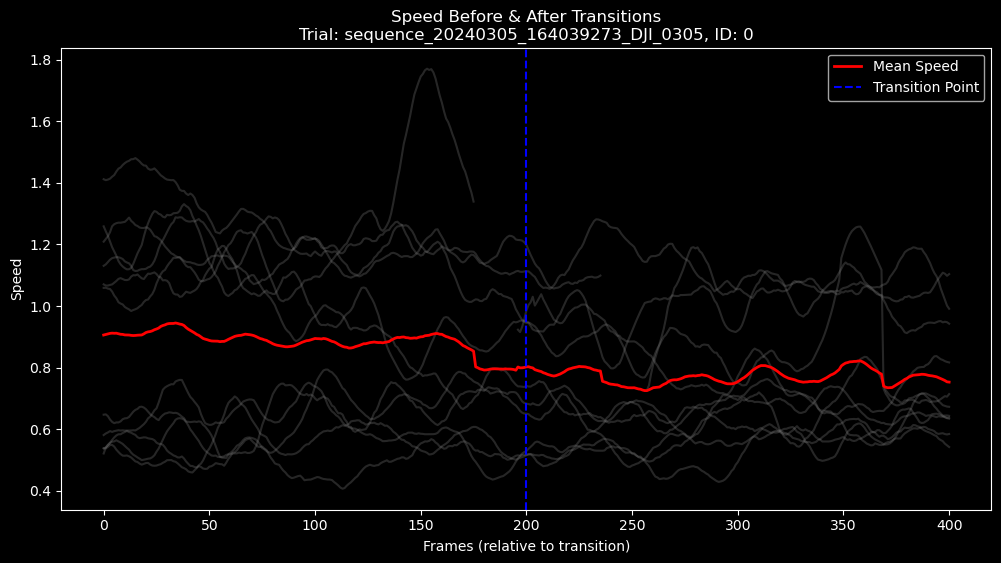

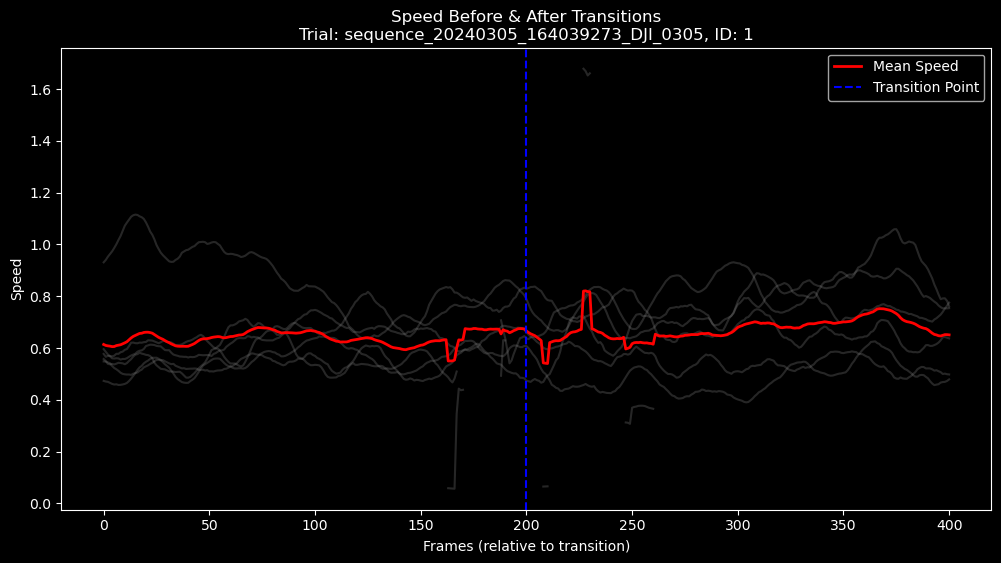

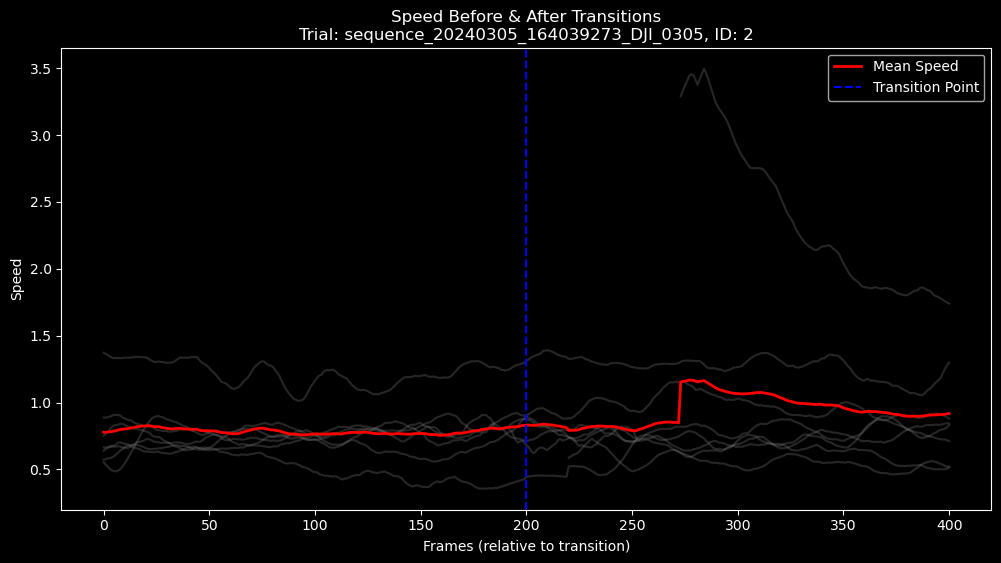

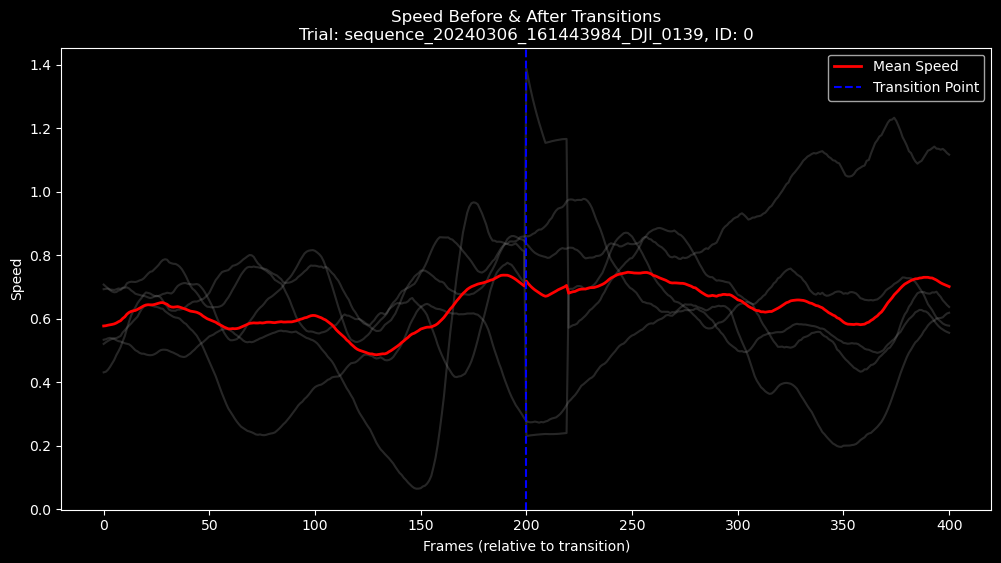

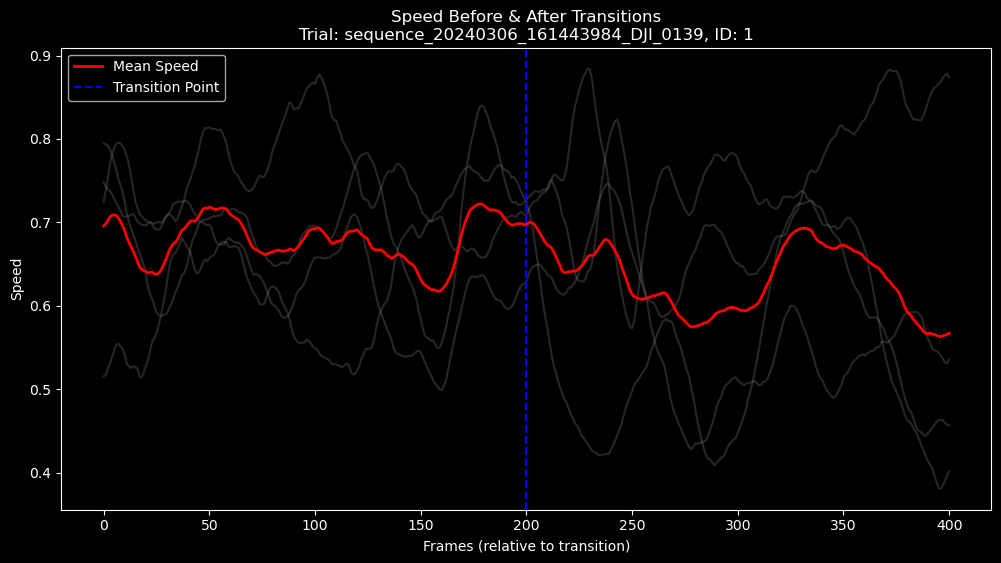

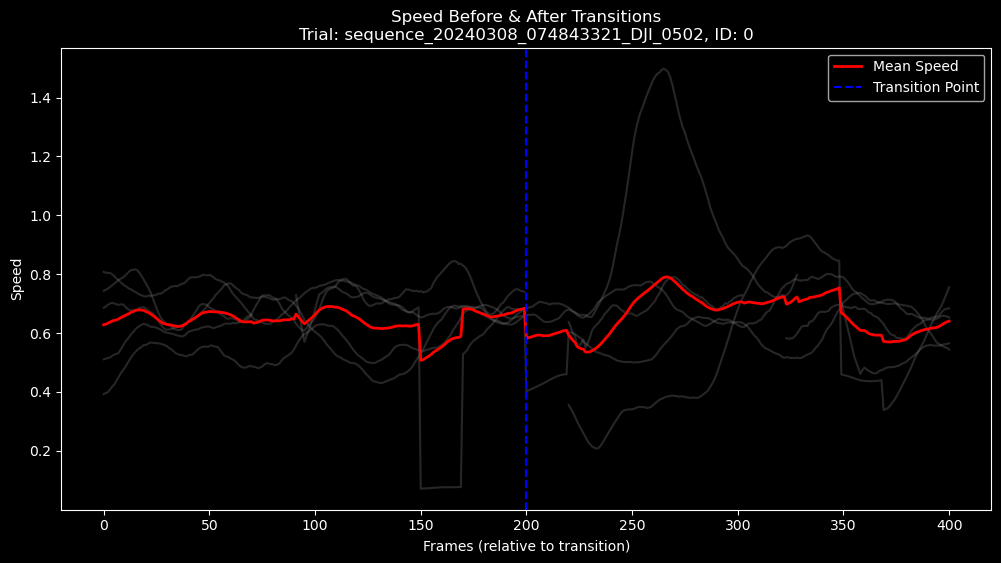

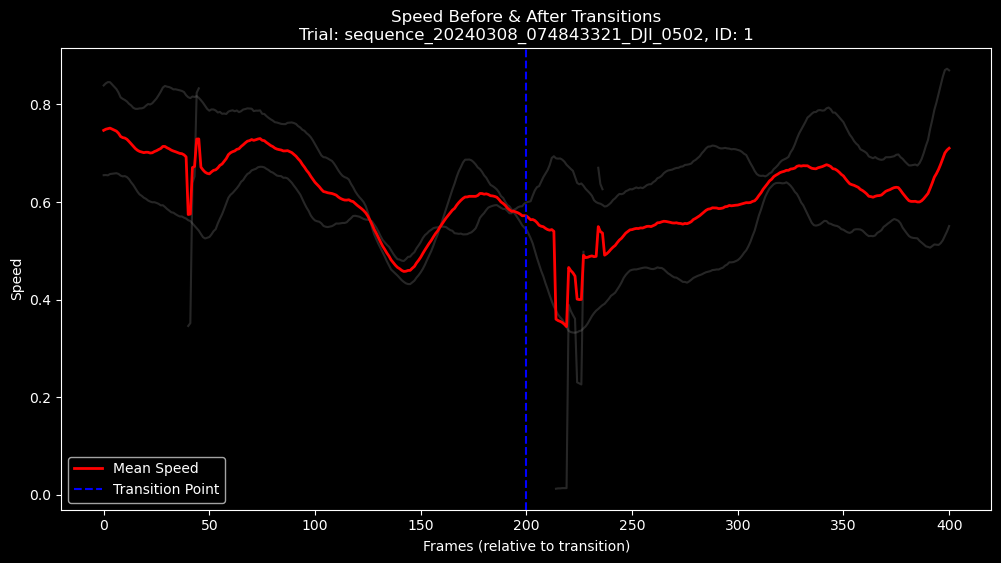

In [9]:

# Process each (Trial, ID) combination separately
for (trial_id, fish_id), group_data in df_speed.groupby(["Trial", "ID"]):  
    group_data = group_data.reset_index(drop=True)  

    # Find indices where 'carangids' changes from 0 to 1 within the group
    transition_indices = group_data.index[(group_data["carangids"].diff() == -1)].tolist()

    # Skip if no transitions are found
    if not transition_indices:
        continue  

    # Store all speed trajectories for this (Trial, ID)
    all_speeds = []

    # Extract speed data around each transition
    for idx in transition_indices:
        if idx >= 200 and idx + 200 < len(group_data):  # Ensure valid range
            speed_segment = group_data.loc[idx - 200: idx + 200, "standardized_speed"].reset_index(drop=True)
            all_speeds.append(speed_segment)

    # If no valid transitions remain, skip plotting
    if not all_speeds:
        continue  

    # Convert to DataFrame for easy plotting
    speed_df = pd.DataFrame(all_speeds).T
    speed_df.columns = [f"Transition_{i}" for i in range(len(all_speeds))]

    # Check if there is actual data to plot (avoid empty plots)
    if speed_df.shape[1] == 0:
        continue  

    # Plot the speed around transitions for this (Trial, ID)
    plt.figure(figsize=(12, 6))
    plt.plot(speed_df, alpha=0.3, color='gray')  # Individual transitions
    plt.plot(speed_df.mean(axis=1), color='red', linewidth=2, label="Mean Speed")  # Mean trend
    plt.axvline(x=200, color='blue', linestyle='--', label="Transition Point")
    plt.xlabel("Frames (relative to transition)")
    plt.ylabel("Speed")
    plt.title(f"Speed Before & After Transitions\nTrial: {trial_id}, ID: {fish_id}")
    plt.legend()
    plt.show()


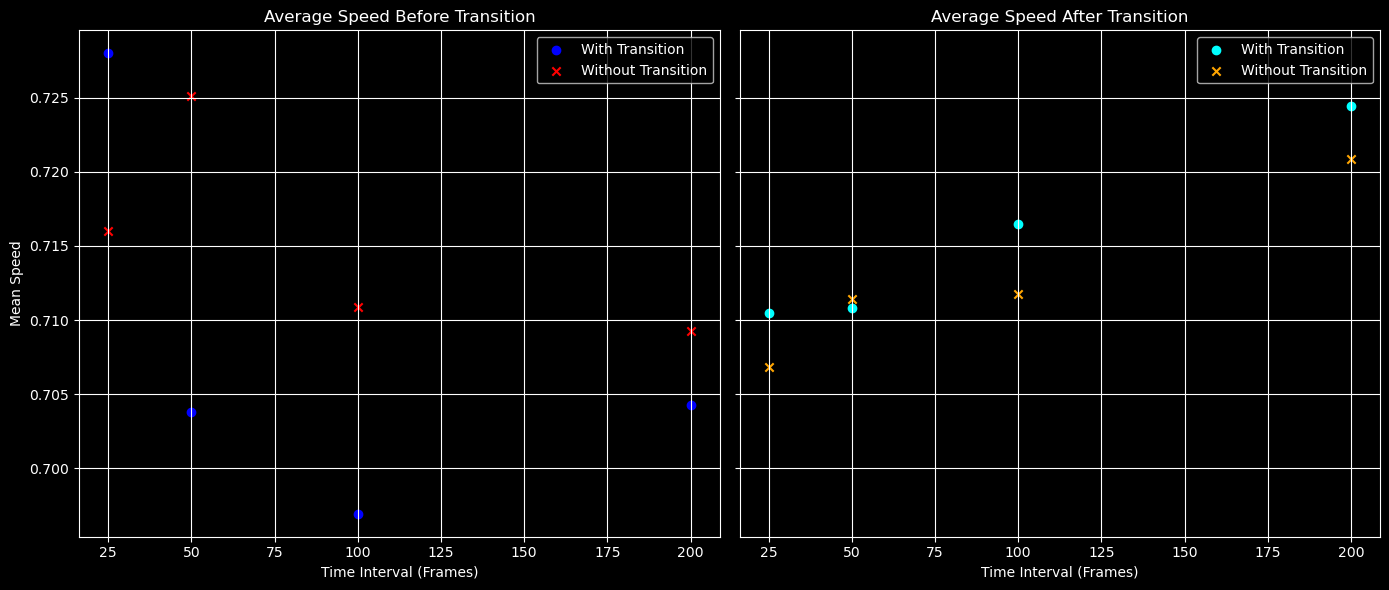

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Store results
mean_speeds_intervals = {
    "Interval (Frames)": [25, 50, 100, 200],  # Time intervals
    "With Transition (Before)": {interval: [] for interval in [25, 50, 100, 200]},
    "With Transition (After)": {interval: [] for interval in [25, 50, 100, 200]},
    "Without Transition (Before)": {interval: [] for interval in [25, 50, 100, 200]},
    "Without Transition (After)": {interval: [] for interval in [25, 50, 100, 200]}
}

# Process each transition and calculate mean speed for the specified intervals
for (trial_id, id_value), trial_data in df.groupby(["Trial", "ID"]):
    trial_data = trial_data.reset_index(drop=True)

    # Find transition indices where 'carangids' changes from 0 to 1
    transition_indices = trial_data.index[(trial_data["carangids"].diff() == -1)].tolist()

    for idx in transition_indices:
        if idx >= 200 and idx + 200 < len(trial_data):  # Ensure valid range
            # Extract the frames before and after the transition for different intervals
            for interval in [25, 50, 100, 200]:
                frame_range_before = trial_data.loc[idx - interval: idx - 1, "frame"].values
                frame_range_after = trial_data.loc[idx: idx + interval - 1, "frame"].values

                # Mean speed for ID with transition (Before and After)
                id_with_transition_data_before = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_before)) &
                    (df["ID"] == id_value)
                ]["standardized_speed"].mean()

                id_with_transition_data_after = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_after)) &
                    (df["ID"] == id_value)
                ]["standardized_speed"].mean()

                # Mean speed for other IDs without transition (Before and After)
                other_ids_data_before = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_before)) &
                    (df["ID"] != id_value)
                ]["standardized_speed"].mean()

                other_ids_data_after = df[
                    (df["Trial"] == trial_id) &
                    (df["frame"].isin(frame_range_after)) &
                    (df["ID"] != id_value)
                ]["standardized_speed"].mean()

                # Store data
                mean_speeds_intervals["With Transition (Before)"][interval].append(id_with_transition_data_before)
                mean_speeds_intervals["With Transition (After)"][interval].append(id_with_transition_data_after)
                mean_speeds_intervals["Without Transition (Before)"][interval].append(other_ids_data_before)
                mean_speeds_intervals["Without Transition (After)"][interval].append(other_ids_data_after)

# Compute the final mean across all trials and transitions for each interval
final_means = {
    "Interval (Frames)": [25, 50, 100, 200],
    "With Transition (Before)": [np.nanmean(mean_speeds_intervals["With Transition (Before)"][interval]) for interval in [25, 50, 100, 200]],
    "With Transition (After)": [np.nanmean(mean_speeds_intervals["With Transition (After)"][interval]) for interval in [25, 50, 100, 200]],
    "Without Transition (Before)": [np.nanmean(mean_speeds_intervals["Without Transition (Before)"][interval]) for interval in [25, 50, 100, 200]],
    "Without Transition (After)": [np.nanmean(mean_speeds_intervals["Without Transition (After)"][interval]) for interval in [25, 50, 100, 200]]
}

# Convert dictionary to DataFrame
mean_speeds_df = pd.DataFrame(final_means)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- First Plot: Before Transition ---
axes[0].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["With Transition (Before)"], color="blue", label="With Transition", marker="o")
axes[0].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["Without Transition (Before)"], color="red", label="Without Transition", marker="x")

axes[0].set_xlabel("Time Interval (Frames)")
axes[0].set_ylabel("Mean Speed")
axes[0].set_title("Average Speed Before Transition")
axes[0].legend()
axes[0].grid(True)

# --- Second Plot: After Transition ---
axes[1].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["With Transition (After)"], color="cyan", label="With Transition", marker="o")
axes[1].scatter(mean_speeds_df["Interval (Frames)"], mean_speeds_df["Without Transition (After)"], color="orange", label="Without Transition", marker="x")

axes[1].set_xlabel("Time Interval (Frames)")
axes[1].set_title("Average Speed After Transition")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
# Store slopes separately
before_slopes = []
after_slopes = []

# Process each Trial separately
for trial_id, trial_data in df.groupby(["Trial", "ID", "segment"]):
    trial_data = trial_data.reset_index(drop=True)
    
    # Find indices where 'carangids' changes from 0 to 1
    transition_indices = trial_data.index[(trial_data["carangids"].diff() == -1)].tolist()
    
    # Extract speed data around each transition and calculate slopes
    for idx in transition_indices:
        if idx >= 100 and idx + 100 < len(trial_data):  # Ensure valid range
            # Get speed values for 50 frames before and after transition
            speed_before = trial_data.loc[idx - 100: idx - 1, "standardized_speed"]
            speed_after = trial_data.loc[idx: idx + 100, "standardized_speed"]

            # Drop NaN values
            speed_before = speed_before.dropna().reset_index(drop=True)
            speed_after = speed_after.dropna().reset_index(drop=True)

            # Create time indices
            time_before = np.arange(-100, 0).reshape(-1, 1)[:len(speed_before)]  # Adjust for NaNs
            time_after = np.arange(0, 101).reshape(-1, 1)[:len(speed_after)]

            # Fit linear regression if enough data points remain
            if len(speed_before) > 1:
                model_before = LinearRegression()
                model_before.fit(time_before, speed_before)
                before_slopes.append(model_before.coef_[0])

            if len(speed_after) > 1:
                model_after = LinearRegression()
                model_after.fit(time_after, speed_after)
                after_slopes.append(model_after.coef_[0])

# Compute the average slopes
average_slope_before = np.mean(before_slopes) if before_slopes else np.nan
average_slope_after = np.mean(after_slopes) if after_slopes else np.nan

# Print results
print(f"Average Slope 50 Frames BEFORE Transition: {average_slope_before:.4f}")
print(f"Average Slope 50 Frames AFTER Transition: {average_slope_after:.4f}")

Average Slope 50 Frames BEFORE Transition: 0.0031
Average Slope 50 Frames AFTER Transition: -0.0014


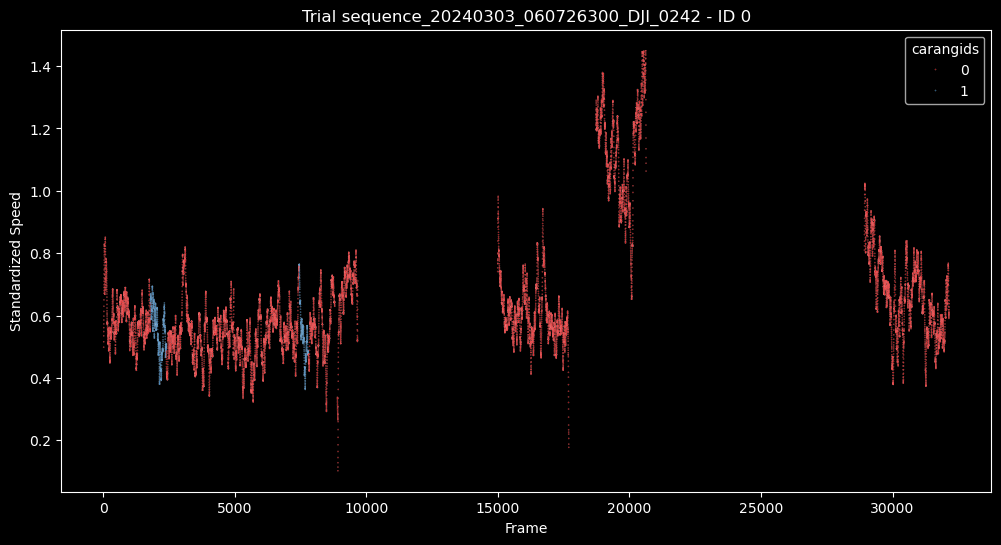

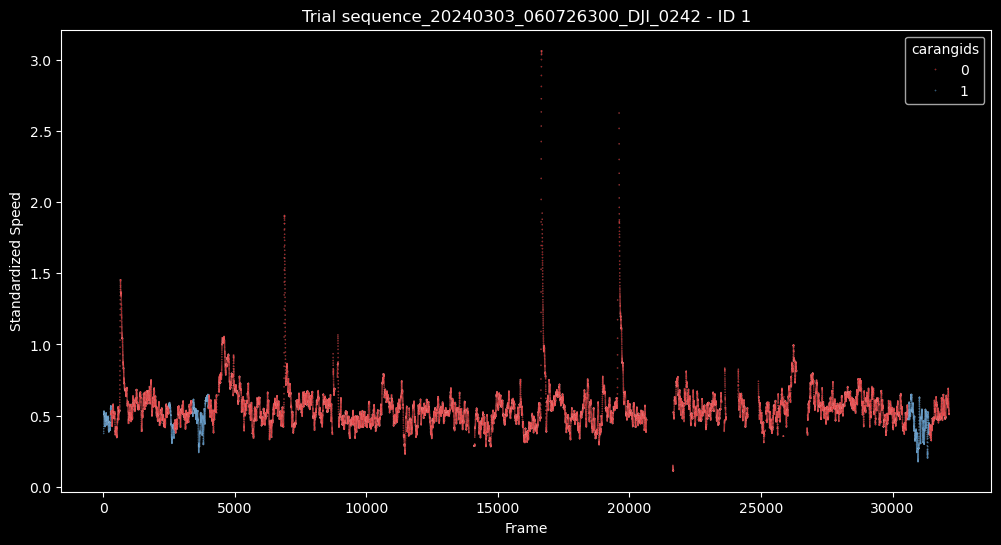

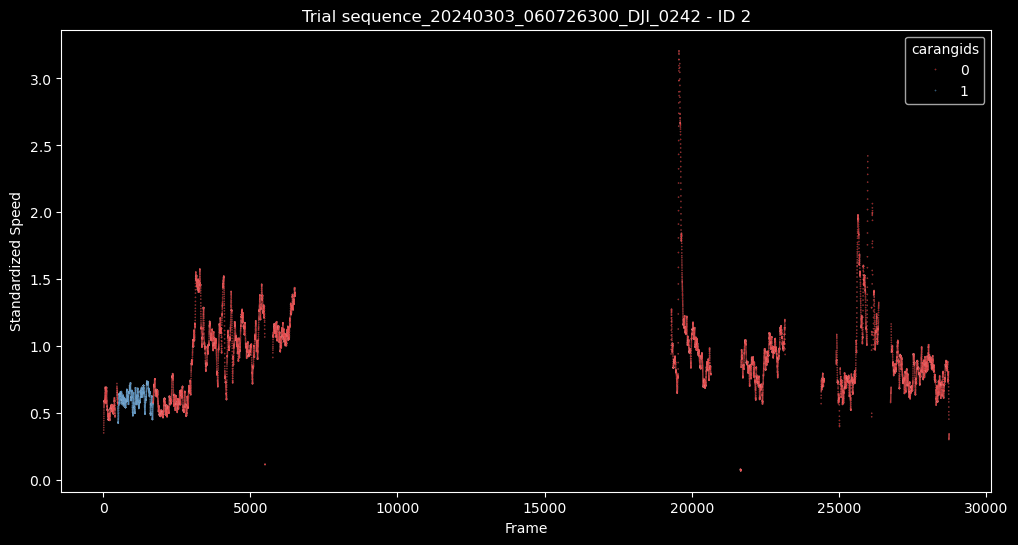

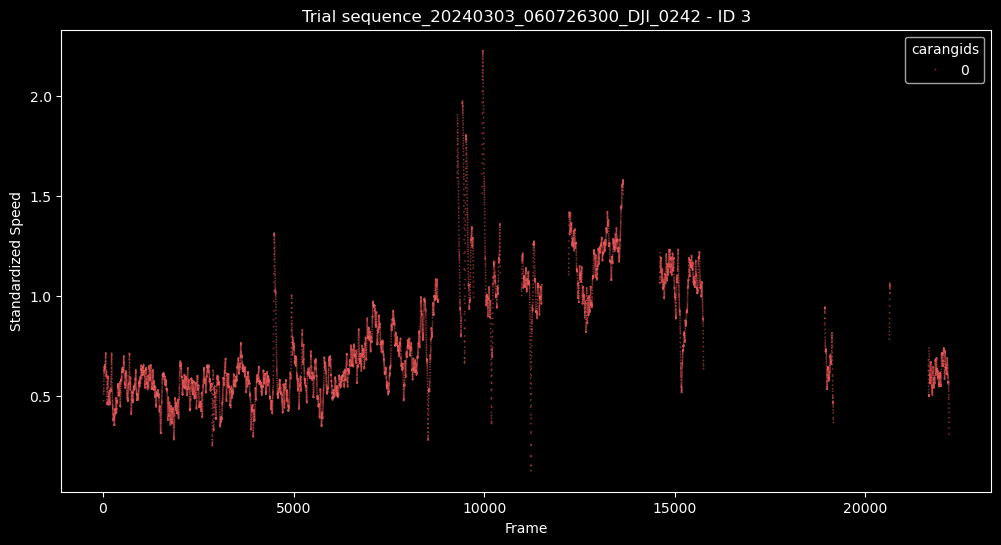

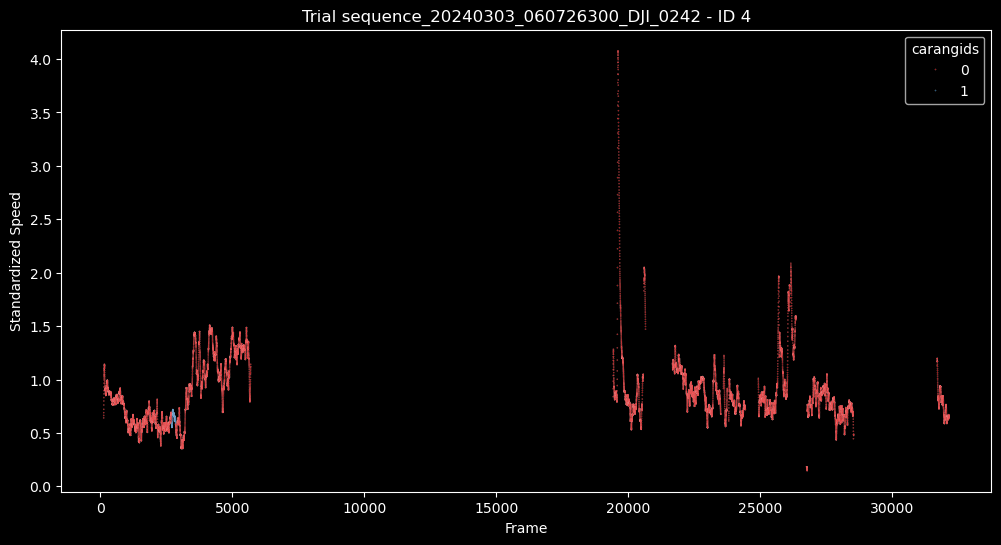

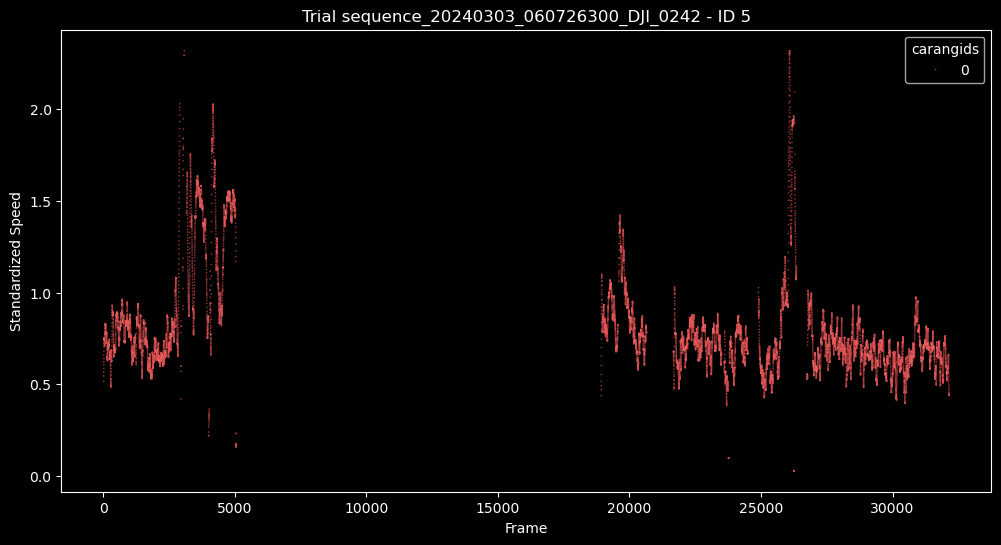

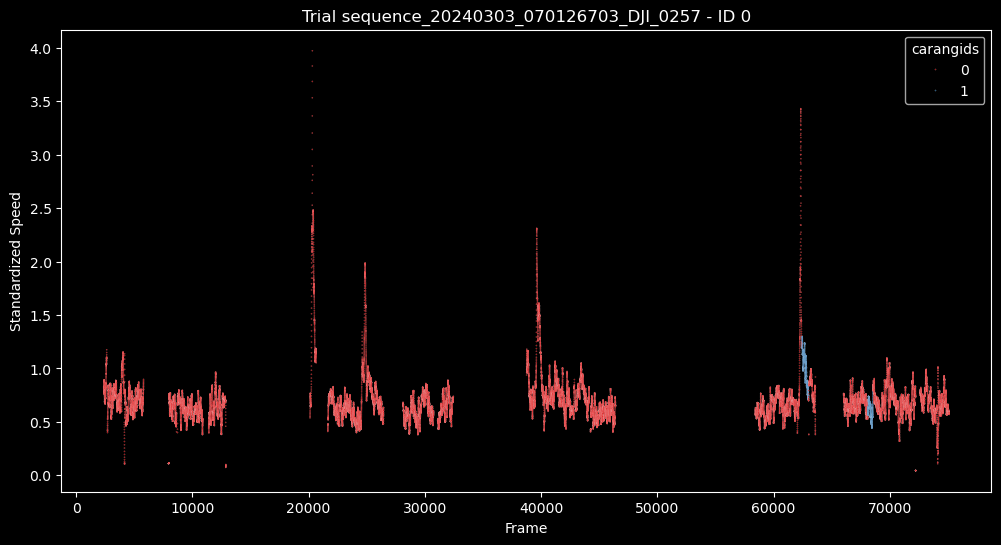

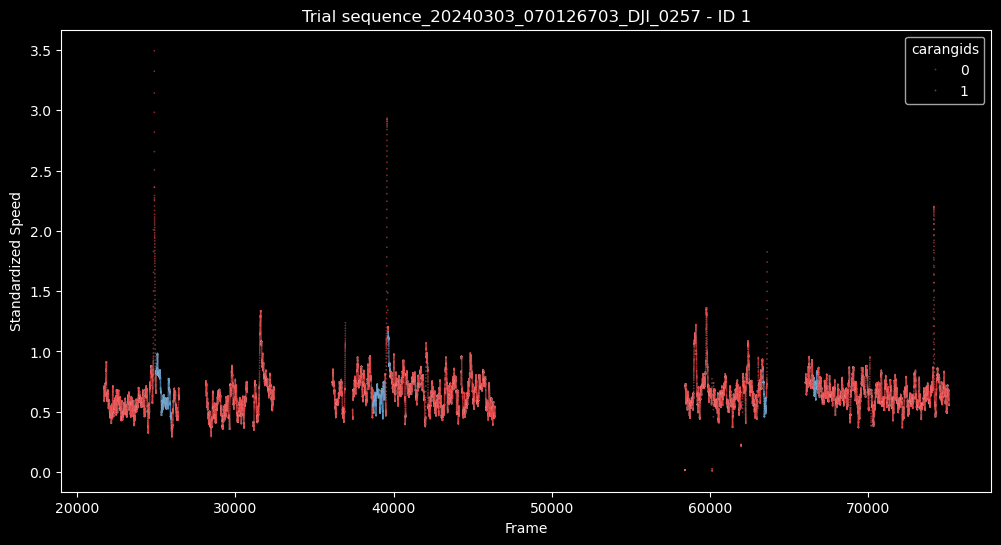

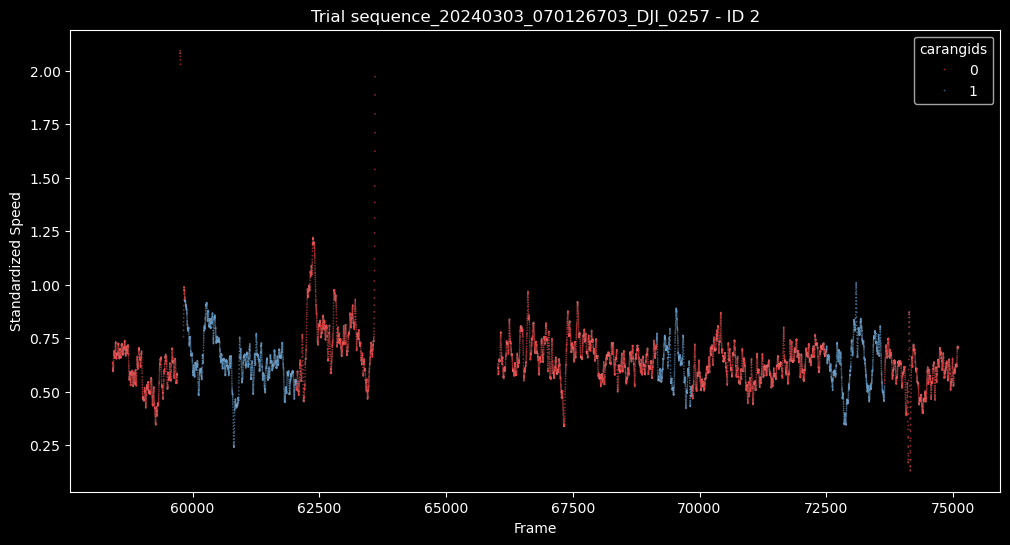

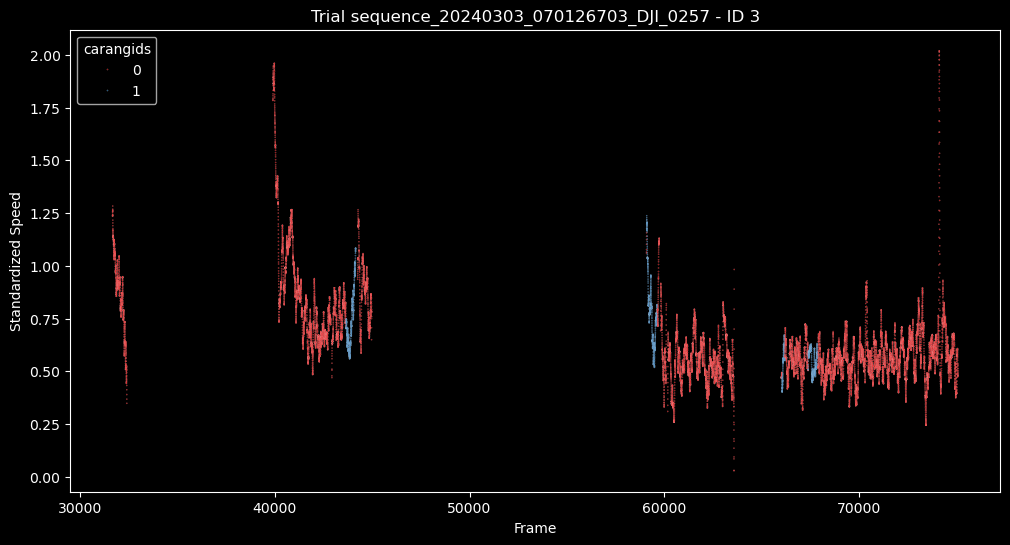

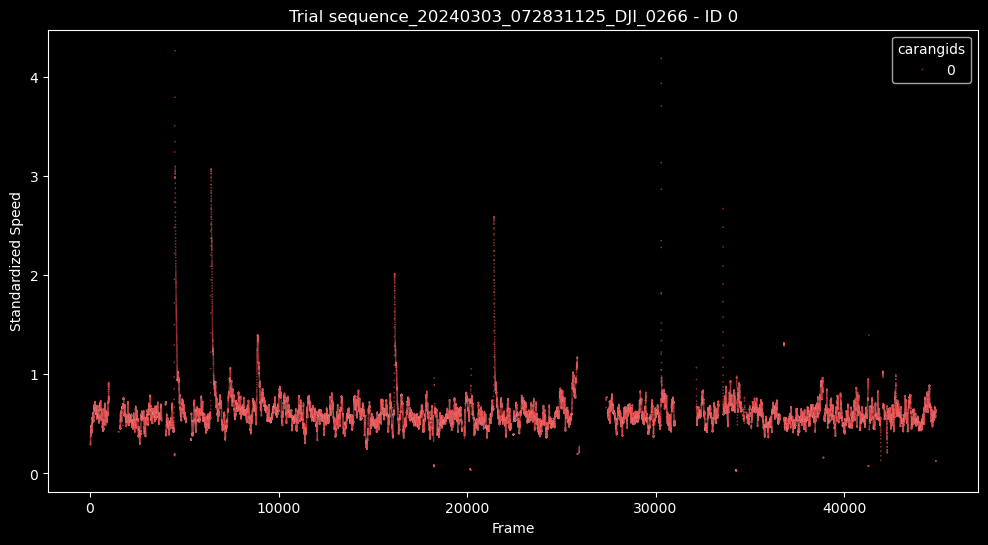

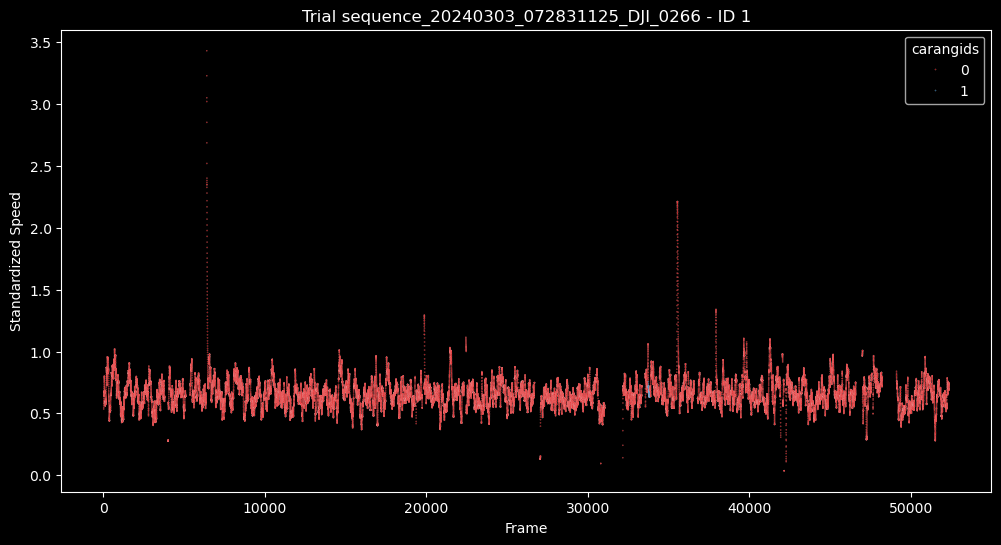

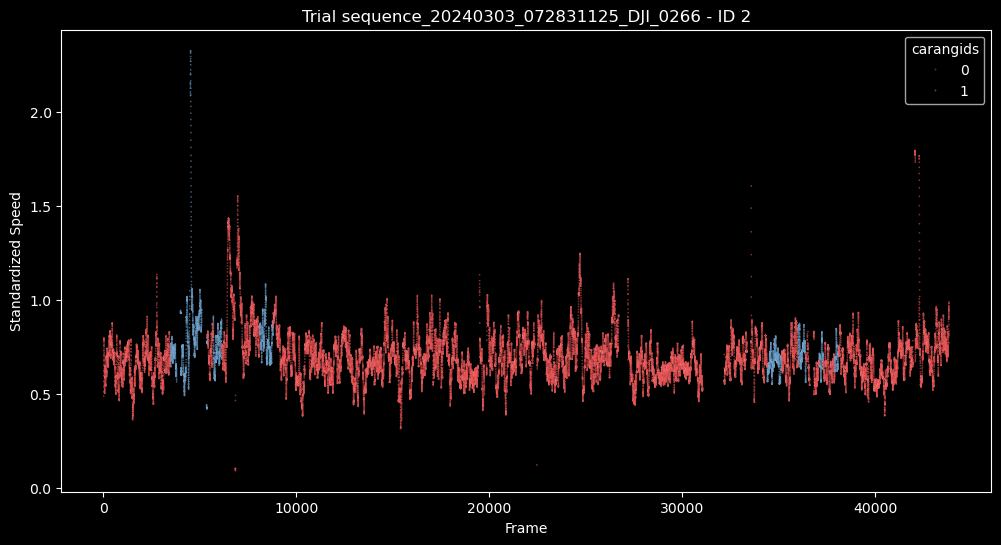

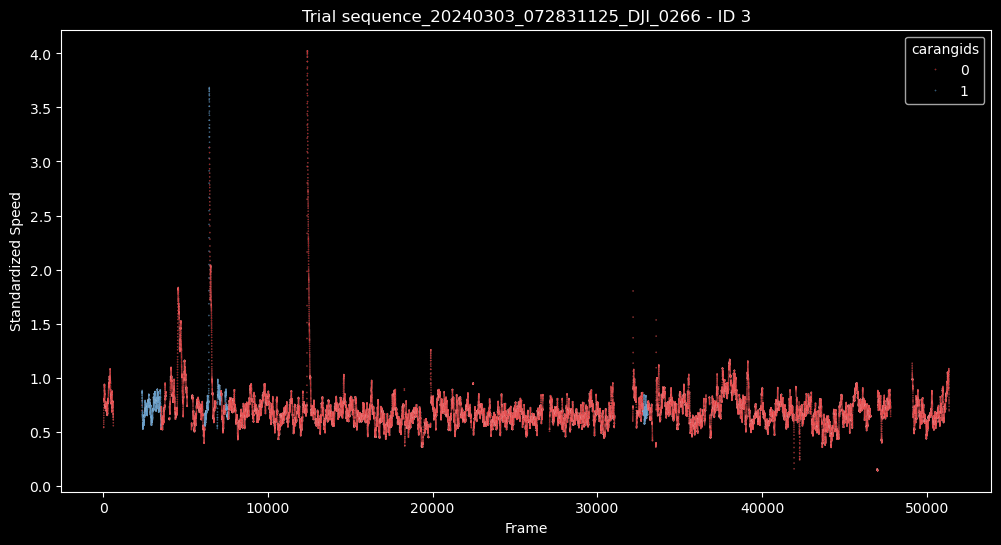

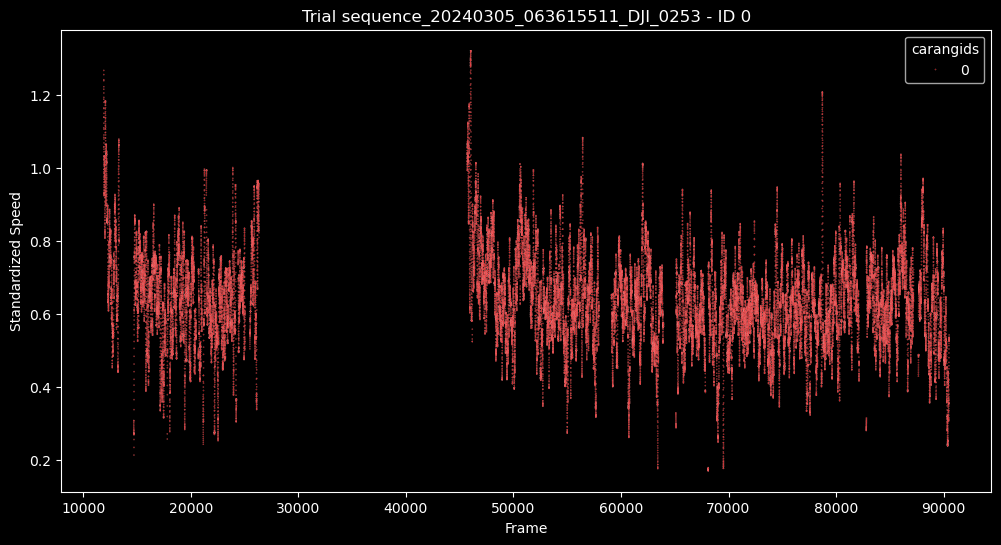

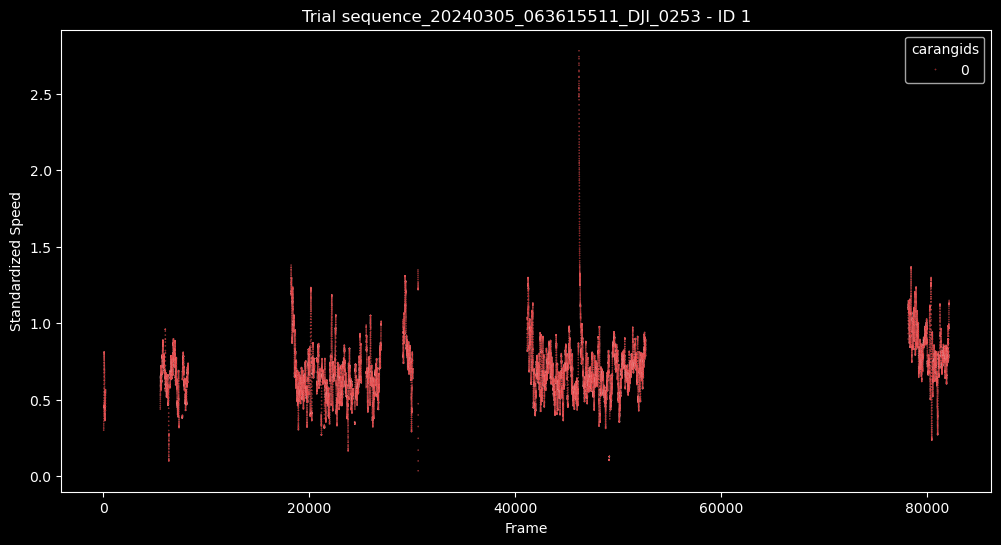

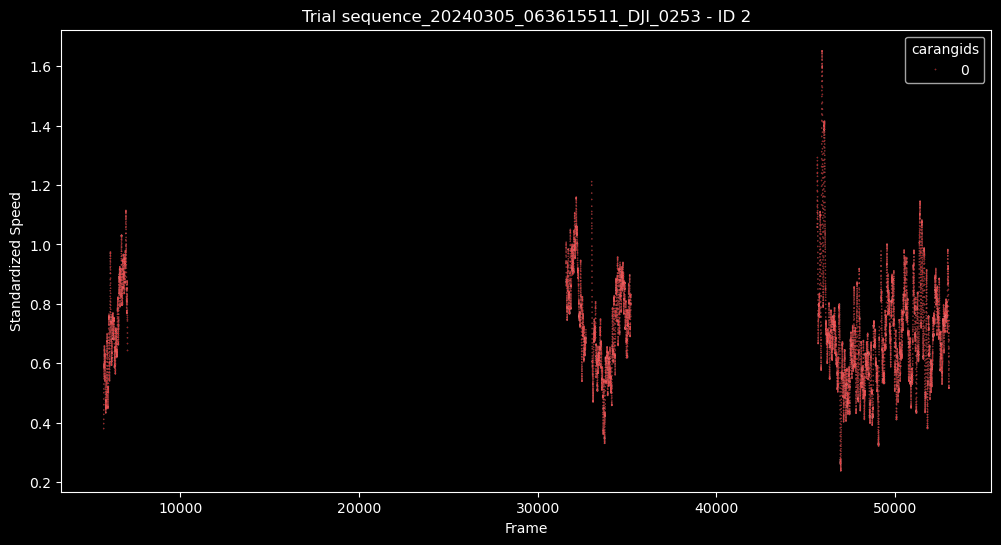

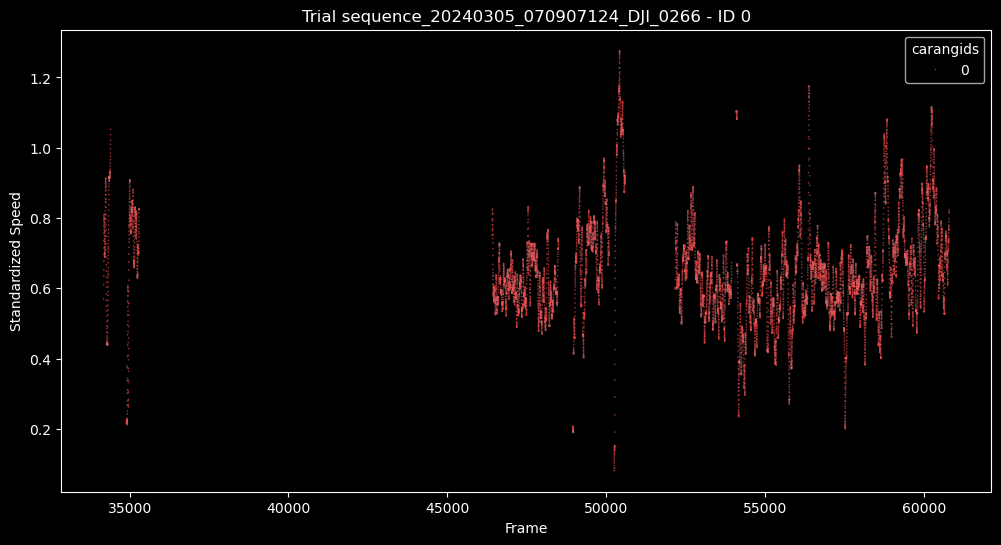

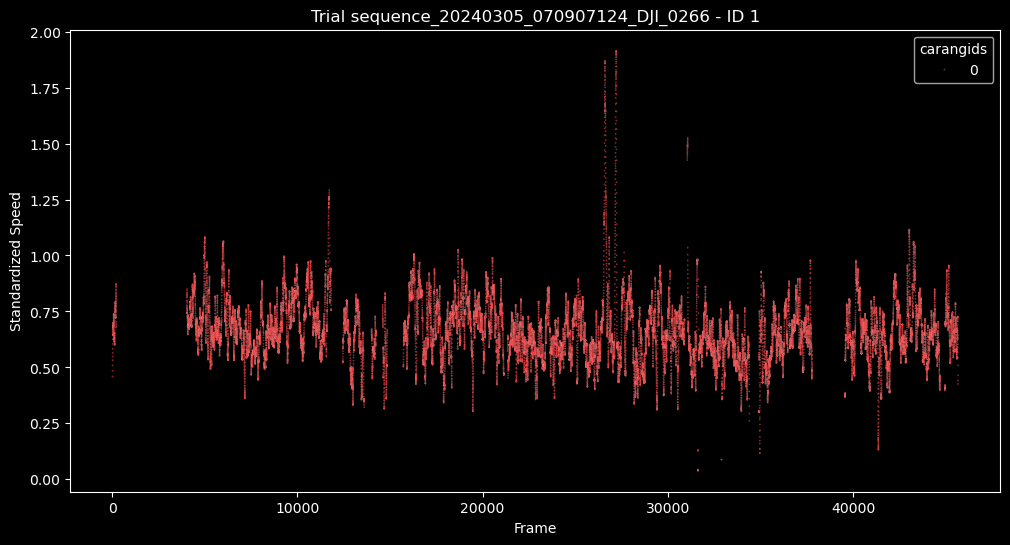

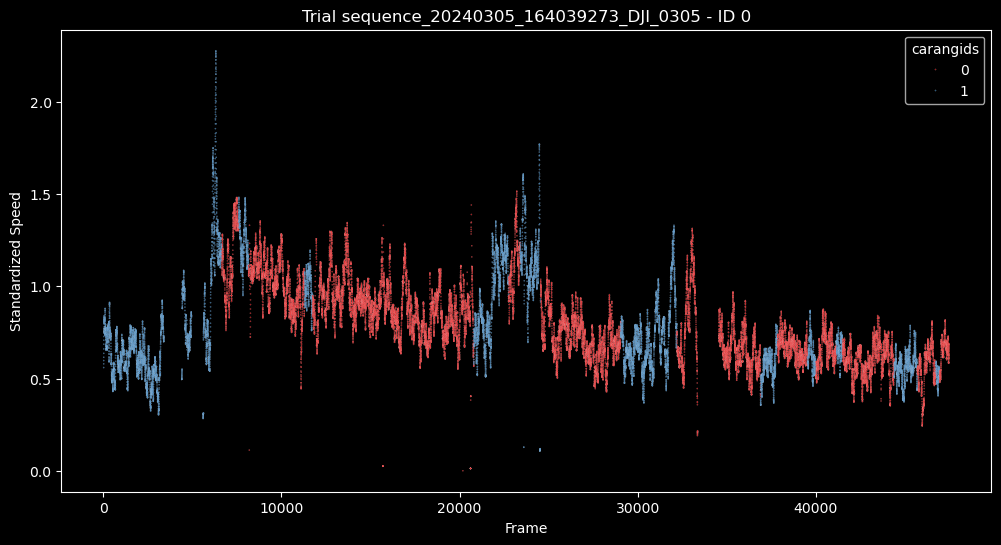

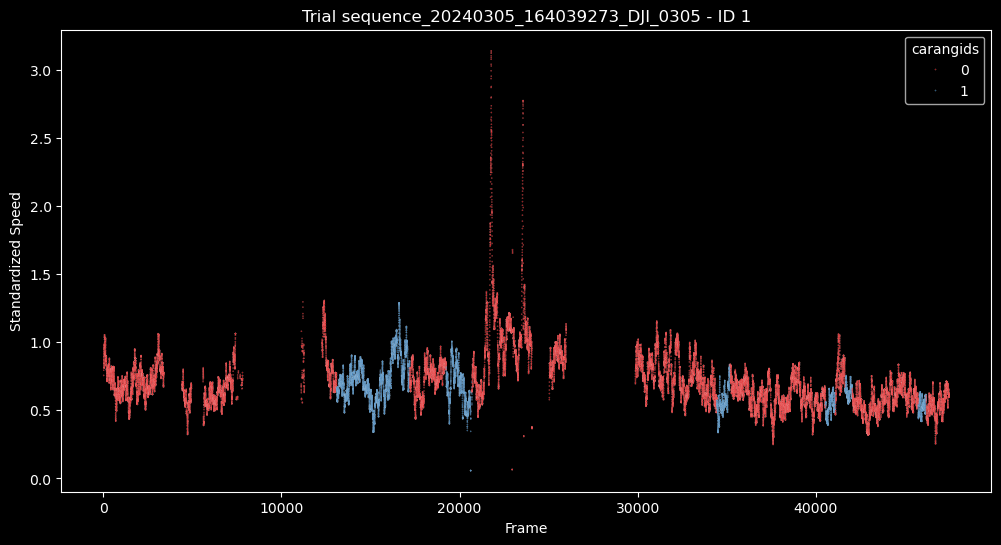

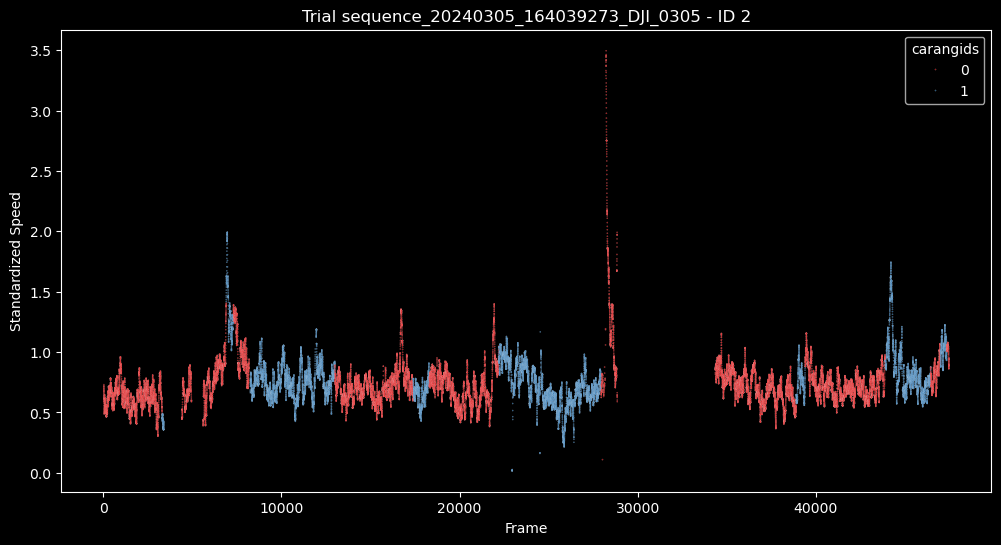

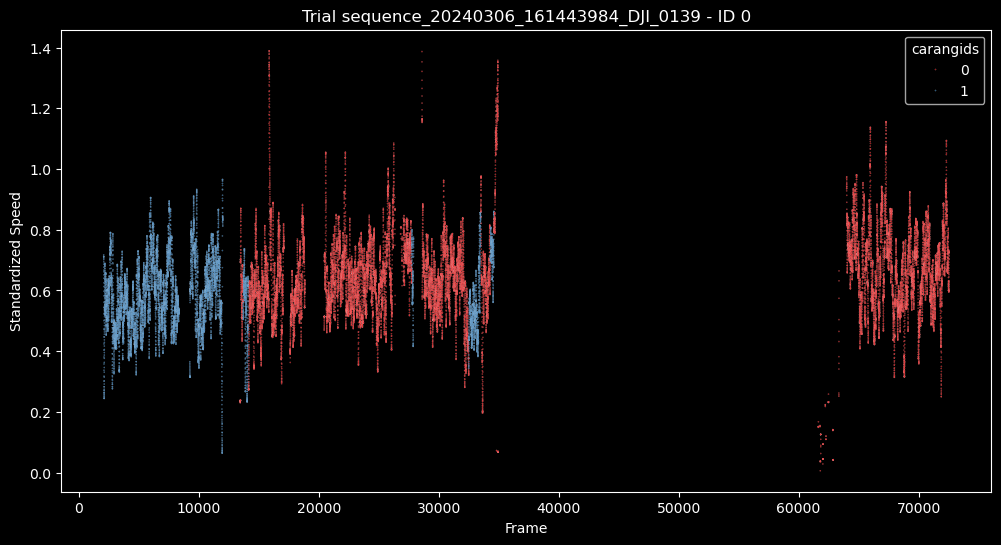

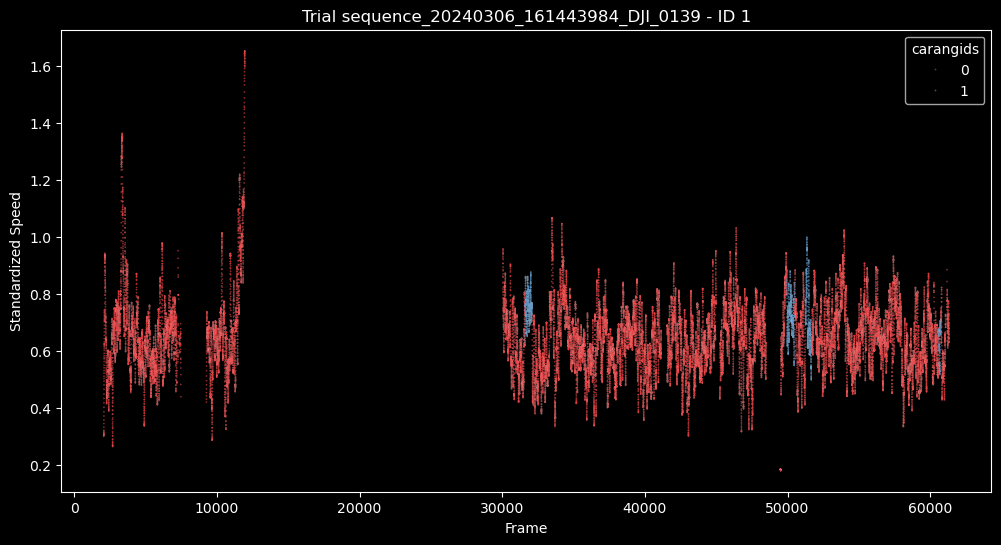

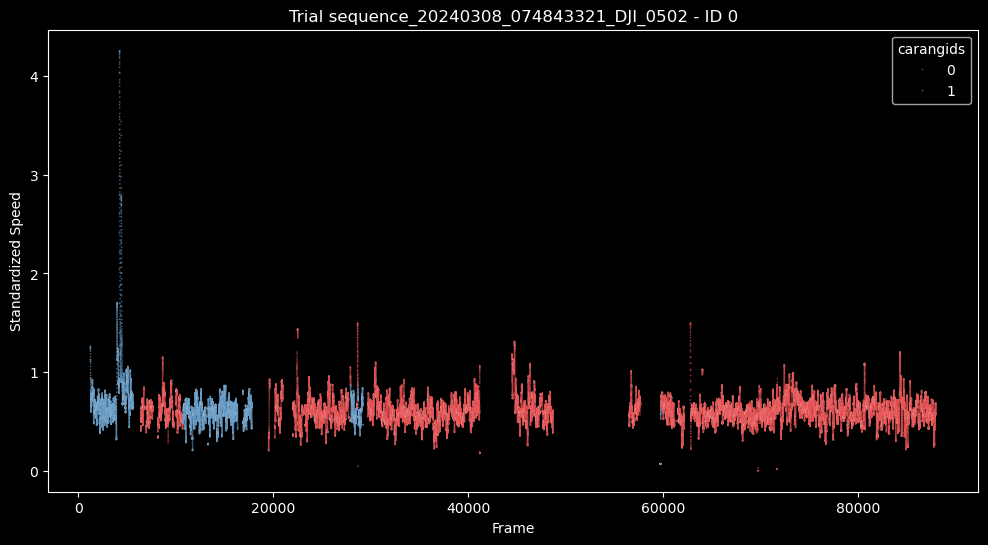

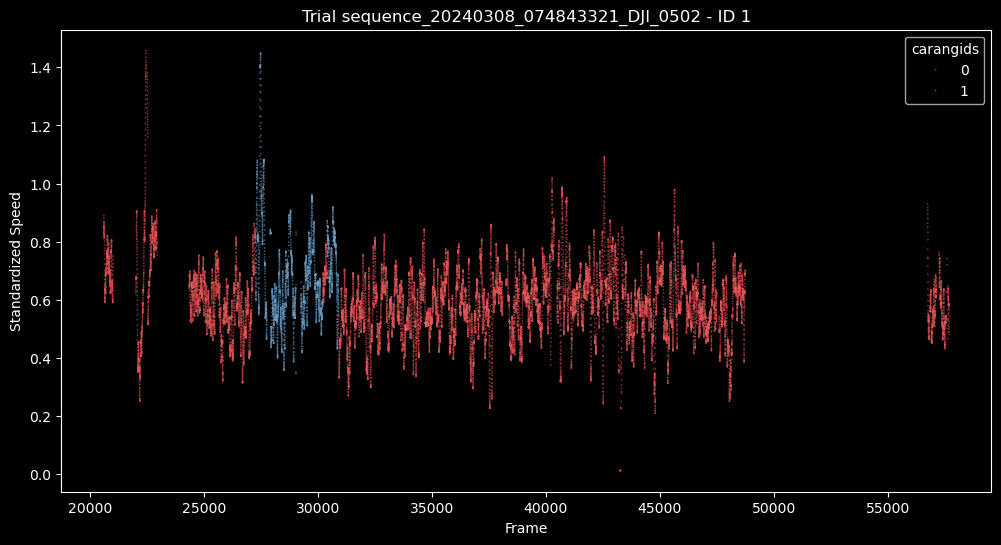

In [17]:
# Loop through each unique Trial
for trial in df_speed['Trial'].unique():
    trial_data = df_speed[df_speed['Trial'] == trial]  # Filter data for the current trial
    
    # Loop through each unique ID in the current trial
    for i in trial_data['ID'].unique():
        plt.figure(figsize=(12, 6))  # Create a new figure for each plot
        
        # Filter the data for the current ID and Trial
        fish_data = trial_data[trial_data['ID'] == i]
        
        # Create the scatter plot with hue based on the 'carangids' column
        sns.scatterplot(x='frame', y='standardized_speed', data=fish_data, hue='carangids', palette="Set1", s=1, alpha=0.7)
        
        # Set the title and labels
        plt.title(f"Trial {trial} - ID {i}")
        plt.xlabel('Frame')
        plt.ylabel('Standardized Speed')
        
        # Show the plot
        plt.show()


C:\Users\sophi\AppData\Local\Temp\ipykernel_29684\1029357418.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_29684\1029357418.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


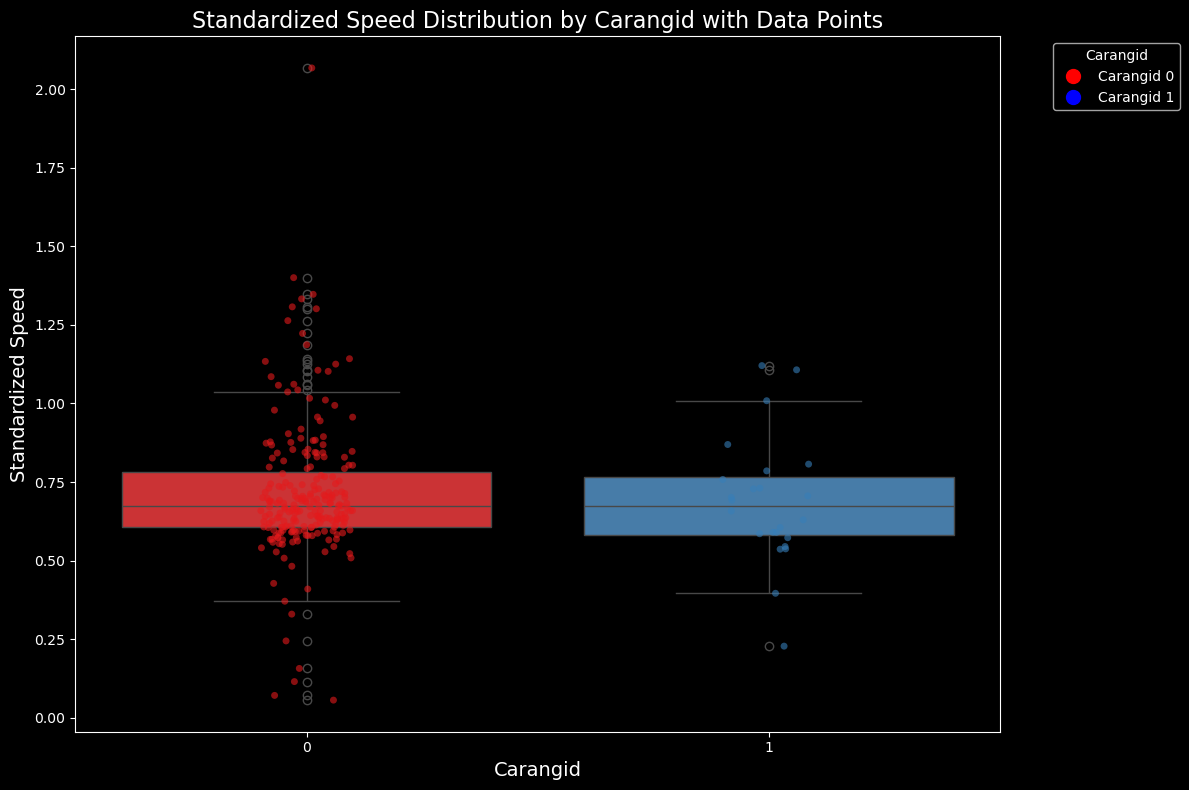

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate averages for multiple metrics with filtering
def calculate_segment_averages(data, metrics, min_count=100):
    averages = []
    for trial, trial_data in data.groupby('Trial'):
        for id_, id_data in trial_data.groupby('ID'):
            for segment, segment_data in id_data.groupby('segment'):  # Group by 'segment'
                if len(segment_data) >= min_count:  # Filter by minimum count
                    avg_values = {metric: segment_data[metric].mean() for metric in metrics}
                    avg_values['Trial'] = trial  # Add Trial information
                    avg_values['Carangid'] = segment_data['carangids'].iloc[0]  # Add carangid info
                    averages.append(avg_values)  # Append average values for all metrics
    return pd.DataFrame(averages)

# Metrics to plot
metrics = ['standardized_speed']

# Calculate the averages for the metrics
avg_df = calculate_segment_averages(df_speed, metrics)

# Ensure 'Carangid' is treated as a categorical variable
avg_df['Carangid'] = avg_df['Carangid'].astype('category')

# Define color palette for carangid (0: red, 1: blue) with string keys to match the data
palette="Set1"

# Create plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 8))

    # Box plot for the current metric, with x as 'Carangid' and the specified color palette
    sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)

    # Overlay strip plot for data points with the same color palette
    sns.stripplot(
        x="Carangid", y=metric, data=avg_df, palette=palette, marker="o", alpha=0.6, jitter=True
    )

    # Add legend using Carangid values (0: red, 1: blue)
    handles = [
        plt.Line2D([0], [0], marker='o', color='red', linestyle='', markersize=10, label='Carangid 0'),
        plt.Line2D([0], [0], marker='o', color='blue', linestyle='', markersize=10, label='Carangid 1')
    ]
    plt.legend(handles=handles, title='Carangid', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Title and labels
    plt.title(f'{metric.replace("_", " ").title()} Distribution by Carangid with Data Points', fontsize=16)
    plt.xlabel("Carangid", fontsize=14)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=14)

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()



C:\Users\sophi\AppData\Local\Temp\ipykernel_9016\3754153097.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trial", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_9016\3754153097.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


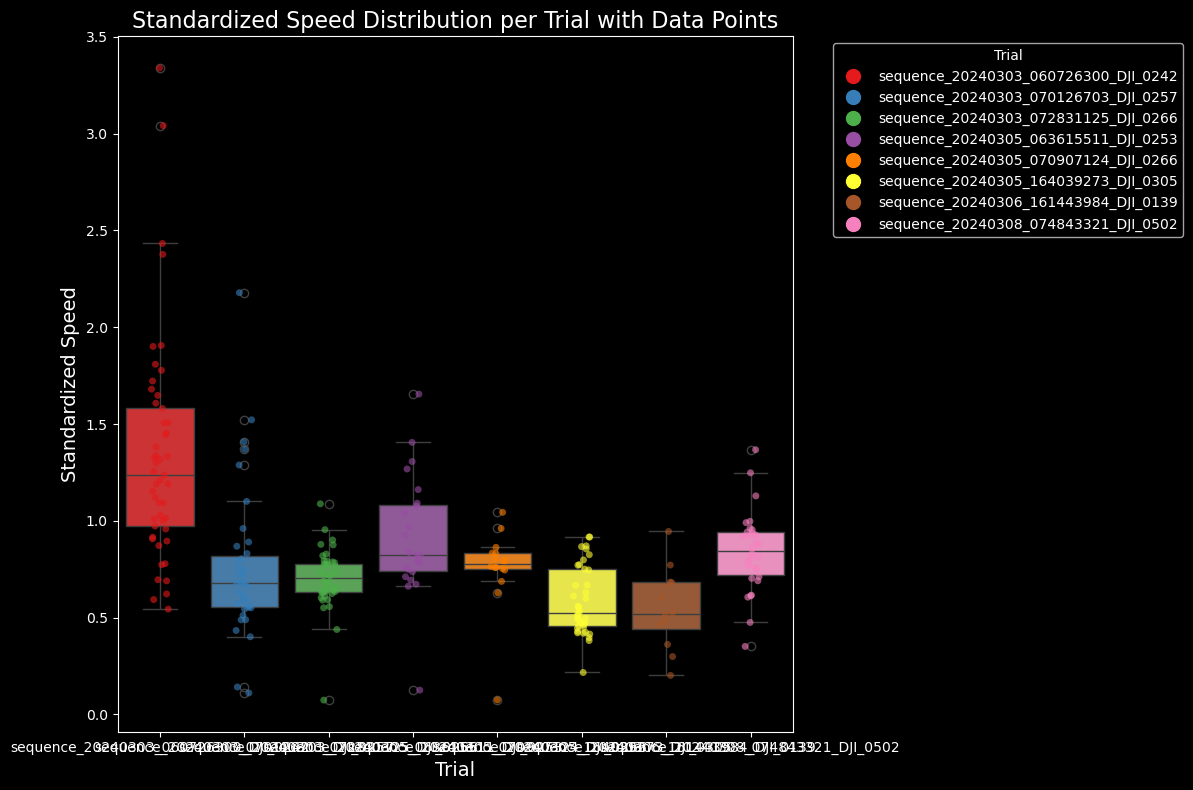

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate averages for a metric with filtering
def calculate_segment_averages(data, metric, min_count=100):
    averages = []
    trials = []
    for trial, trial_data in data.groupby('Trial'):
        for id_, id_data in trial_data.groupby('ID'):
            for segment, segment_data in id_data.groupby('segment'):  # Group by 'segment'
                if len(segment_data) >= min_count:  # Filter by minimum count
                    avg_value = segment_data[metric].mean()
                    averages.append({'Trial': trial, metric: avg_value})  # Append trial and average value
    return pd.DataFrame(averages)

# Metric to plot
metric = 'standardized_speed'

# Calculate the averages for the given metric
avg_df = calculate_segment_averages(df_speed, metric)

# Create the plot
plt.figure(figsize=(12, 8))

# Generate unique colors for each Trial
palette = sns.color_palette("Set1", n_colors=avg_df['Trial'].nunique())

# Box plot for the metric
sns.boxplot(x="Trial", y=metric, data=avg_df, palette=palette)

# Overlay strip plot for data points with the same palette
sns.stripplot(
    x="Trial", y=metric, data=avg_df, palette=palette, marker="o", alpha=0.6, jitter=True
)

# Add legend using unique Trial names
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[i], linestyle='', markersize=10, label=trial)
    for i, trial in enumerate(avg_df['Trial'].unique())
]
plt.legend(handles=handles, title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Title and labels
plt.title(f'{metric.replace("_", " ").title()} Distribution per Trial with Data Points', fontsize=16)
plt.xlabel("Trial", fontsize=14)
plt.ylabel(metric.replace("_", " ").title(), fontsize=14)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(figures_path +'plotnnd1.png')
plt.show()

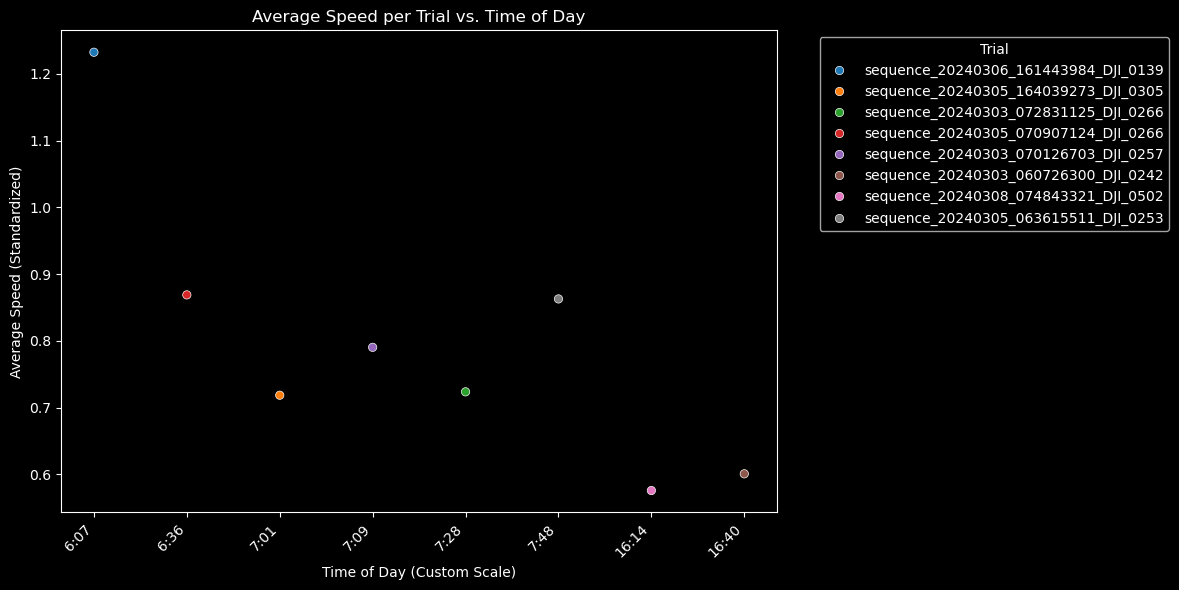

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to parse the time of day from the trial name
def parse_start_time(trial_name):
    time_part = trial_name.split('_')[2]  # Extract the time from the trial name (HHMMSSsss)
    time_str = f"{time_part[:2]}:{time_part[2:4]}:{time_part[4:6]}.{time_part[6:]}"  # Format time
    return datetime.strptime(time_str, '%H:%M:%S.%f').time()  # Convert to time object

# Convert time to seconds since midnight
def time_to_seconds(time_obj):
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1e6

# Calculate average nearest neighbor distance for each trial
average_nnds = []
trial_start_times = []

for trial, trial_data in df_speed.groupby('Trial'):
    avg_nnd = trial_data['standardized_speed'].mean()  # Compute the average nearest neighbor distance for the trial
    start_time = parse_start_time(trial)  # Get the start time of the trial (time of day)
    average_nnds.append(avg_nnd)
    trial_start_times.append(start_time)

# Create a DataFrame for the average distances and start times
avg_nnd_df = pd.DataFrame({
    'Trial': list(df_speed['Trial'].unique()),  # Convert to list for consistent ordering
    'avg_nnd': average_nnds,
    'start_time': trial_start_times
})

# Convert start time to seconds for plotting
avg_nnd_df['start_time_seconds'] = avg_nnd_df['start_time'].apply(time_to_seconds)

# Custom mapping: Re-scale time
valid_seconds = avg_nnd_df['start_time_seconds'].sort_values().unique()
custom_x_mapping = {v: i for i, v in enumerate(valid_seconds)}
avg_nnd_df['custom_x'] = avg_nnd_df['start_time_seconds'].map(custom_x_mapping)

# Plot the data using seaborn
plt.figure(figsize=(12, 6))

# Scatter plot with the custom x-axis
sns.scatterplot(
    data=avg_nnd_df, 
    x='custom_x', 
    y='avg_nnd', 
    hue='Trial', 
    palette='tab10'
)

# Add labels and title
plt.xlabel('Time of Day (Custom Scale)')
plt.ylabel('Average Speed (Standardized)')
plt.title('Average Speed per Trial vs. Time of Day')
plt.legend(title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format the x-axis labels with original time
plt.xticks(
    ticks=range(len(valid_seconds)), 
    labels=[str(timedelta(seconds=int(t)))[:-3] for t in valid_seconds], 
    rotation=45, ha='right'
)

plt.tight_layout()
plt.show()

### Averages

In [30]:
df_speed['Trial_num']= df_speed['Trial'].astype('category').cat.codes

In [38]:
# Group by both 'ID' and 'segment' and count the number of frames for each group
id_segment_counts = df_speed.groupby(['ID', 'segment']).size()

# Filter out ID-segment combinations that have less than 100 frames (2 seconds)
id_segments_to_keep = id_segment_counts[id_segment_counts >= 150].index

# Keep only the rows where the combination of 'ID' and 'segment' is in the list of groups with >= 100 frames
dfspeed = df_speed[df_speed.set_index(['ID', 'segment']).index.isin(id_segments_to_keep)]

In [35]:
example_avg_ID = df_speed[['ID','carangids','standardized_speed','Trial_num']].groupby(['carangids','Trial_num','ID']).mean().reset_index()
example_avg_ID

carangids  Trial_num  ID  standardized_speed
0           0          0   0            0.653375
1           0          0   1            0.556667
2           0          0   2            0.920161
3           0          0   3            0.762211
4           0          0   4            0.897101
5           0          0   5            0.812272
6           0          1   0            0.700016
7           0          1   1            0.651806
8           0          1   2            0.651203
9           0          1   3            0.655201
10          0          2   0            0.611873
11          0          2   1            0.660054
12          0          2   2            0.694996
13          0          2   3            0.697794
14          0          3   0            0.635498
15          0          3   1            0.698963
16          0          3   2            0.708000
17          0          4   0            0.649359
18          0          4   1            0.665535
19          0          5   0            0.800108
20          0          5   1            0.717128
21          0          5   2            0.735987
22          0          6   0            0.651008
23          0          6   1            0.644647
24          0          7   0            0.609770
25          0          7   1            0.591614
26          1          0   0            0.542223
27          1          0   1            0.462181
28          1          0   2            0.611401
29          1          0   4            0.643707
30          1          1   0            0.818561
31          1          1   1            0.662204
32          1          1   2            0.637320
33          1          1   3            0.679527
34          1          2   1            0.671933
35          1          2   2            0.756849
36          1          2   3            0.773460
37          1          5   0            0.776519
38          1          5   1            0.674631
39          1          5   2            0.767974
40          1          6   0            0.580286
41          1          6   1            0.720419
42          1          7   0            0.664908
43          1          7   1            0.682982

In [20]:
example_avg = df_speed[['carangids','standardized_speed','Trial_num']].groupby(['carangids','Trial_num']).mean().reset_index()
example_avg

carangids  Trial_num  standardized_speed
0           0          0            0.734397
1           0          1            0.675244
2           0          2            0.667455
3           0          3            0.663722
4           0          4            0.661544
5           0          5            0.752769
6           0          6            0.648303
7           0          7            0.604754
8           1          0            0.527157
9           1          1            0.671618
10          1          2            0.764732
11          1          5            0.753597
12          1          6            0.598703
13          1          7            0.674055

In [39]:
exampleavg = dfspeed[['ID','carangids','standardized_speed','Trial_num','segment']].groupby(['carangids','Trial_num','ID','segment']).mean().reset_index()
exampleavg

carangids  Trial_num  ID  segment  standardized_speed
0            0          0   0        0                 NaN
1            0          0   0        1            0.560092
2            0          0   0        4            0.605036
3            0          0   0        6            1.125331
4            0          0   0        9            0.663569
..         ...        ...  ..      ...                 ...
309          1          7   0       27            0.407027
310          1          7   1        0            0.607743
311          1          7   1        8            0.688432
312          1          7   1       10            0.657655
313          1          7   1       14            0.682677

[314 rows x 5 columns]

C:\Users\sophi\AppData\Local\Temp\ipykernel_16076\2318434098.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carangids',y='standardized_speed',data = exampleavg, palette="Set1")


<Axes: xlabel='carangids', ylabel='standardized_speed'>

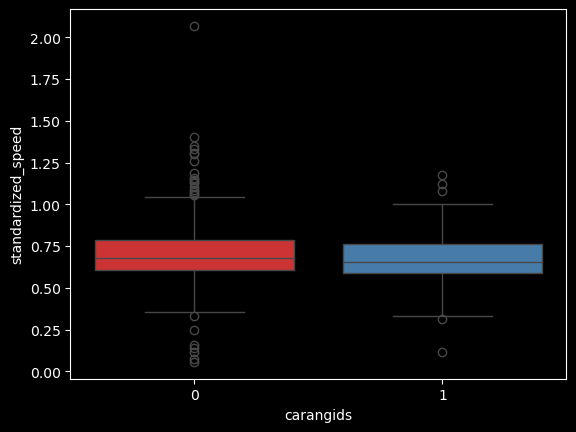

In [40]:
sns.boxplot(x='carangids',y='standardized_speed',data = exampleavg, palette="Set1")

In [17]:
df_speed['Trial_num']= df_speed['Trial'].astype('category').cat.codes

In [42]:
# Filter valid IDs (remove NaN and inf)
valid_ids = df_speed[
   df_speed['midpoint_x'].notna() & ~np.isinf(df_speed['midpoint_x'])]

# Calculate unique IDs per frame
unique_id_count_per_frame = (
    valid_ids
    .groupby(['frame', 'Trial'])
    .agg(unique_id_count=('ID', 'nunique'))
    .reset_index()
)

# Function to calculate the mode of a rolling window
def rolling_mode(series, window_size):
    return series.rolling(window=window_size, min_periods=1).apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan, raw=False)

# Apply rolling window with mode (window of 50 frames)
unique_id_count_per_frame['rolling_mode'] = rolling_mode(unique_id_count_per_frame['unique_id_count'], window_size=50)

In [43]:
subset = df_speed.merge(unique_id_count_per_frame, on=['Trial', 'frame'])

In [44]:
speedID = subset[['unique_id_count','standardized_speed','Trial_num','ID','segment']].groupby(['unique_id_count','Trial_num','ID', 'segment']).mean().reset_index()

C:\Users\sophi\AppData\Local\Temp\ipykernel_16076\3774533668.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unique_id_count',y='standardized_speed',data = speedID, palette='Set1')


<Axes: xlabel='unique_id_count', ylabel='standardized_speed'>

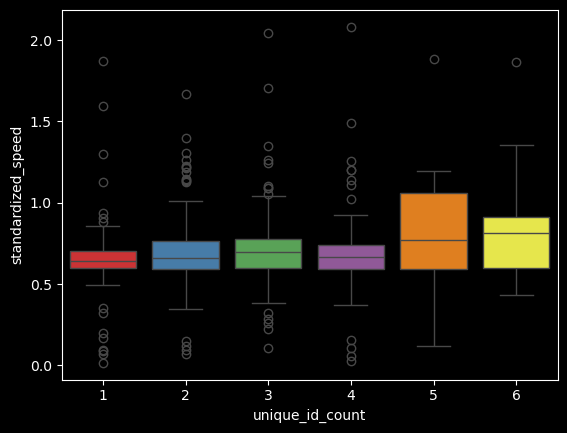

In [45]:
sns.boxplot(x='unique_id_count',y='standardized_speed',data = speedID, palette='Set1')

### Autocorrelation

   ID  segment                                 Trial  lag  autocorrelation
0   0        1  sequence_20240303_060726300_DJI_0242    0         1.000000
1   0        1  sequence_20240303_060726300_DJI_0242    1         0.997911
2   0        1  sequence_20240303_060726300_DJI_0242    2         0.993345
3   0        1  sequence_20240303_060726300_DJI_0242    3         0.986615
4   0        1  sequence_20240303_060726300_DJI_0242    4         0.978033


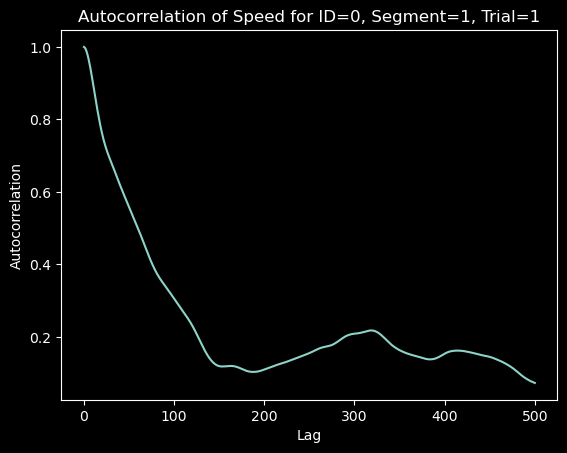

In [75]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def autocorrelation(x, max_lag=30):
    """
    Calculate autocorrelation for a time series up to a maximum lag.
    
    Parameters:
    - x: A pandas Series or numpy array containing the speed values.
    - max_lag: The maximum number of lags to compute autocorrelation for.
    
    Returns:
    - A numpy array containing autocorrelation values for lags 0 to max_lag.
    """
    autocorr_values = []
    for lag in range(max_lag + 1):
        # Compute the autocorrelation at lag 'lag'
        autocorr = np.corrcoef(x[:-lag] if lag != 0 else x, x[lag:])[0, 1] if lag != 0 else 1
        autocorr_values.append(autocorr)
    return np.array(autocorr_values)

def calculate_autocorrelation_for_group(group, speed_col, max_lag):
    """
    Calculate autocorrelation for a single group (ID, segment, Trial).
    
    Parameters:
    - group: A pandas DataFrame for a specific group (ID, segment, Trial).
    - speed_col: The column name containing speed values.
    - max_lag: The maximum number of lags for autocorrelation.
    
    Returns:
    - A DataFrame with autocorrelation values for the group.
    """
    # Extract the speed values for the group
    speed_values = group[speed_col].dropna().values
    
    if len(speed_values) > max_lag:
        # Calculate autocorrelation for this group
        autocorr = autocorrelation(speed_values, max_lag)
        
        # Create a DataFrame with the autocorrelation results
        autocorr_results = {
            'ID': group['ID'].iloc[0],
            'segment': group['segment'].iloc[0],
            'Trial': group['Trial'].iloc[0],
            'lag': np.arange(len(autocorr)),
            'autocorrelation': autocorr
        }
        
        return pd.DataFrame(autocorr_results)
    return pd.DataFrame()

def calculate_autocorrelation_per_id_segment(df, speed_col, max_lag=30, n_jobs=-1):
    """
    Calculate autocorrelation for speed for each unique ID, segment, and Trial.
    
    Parameters:
    - df: A pandas DataFrame containing columns for speed, ID, segment, and Trial.
    - speed_col: The column name containing speed values.
    - max_lag: The maximum lag for autocorrelation.
    - n_jobs: The number of jobs to run in parallel. If -1, use all available cores.
    
    Returns:
    - DataFrame: The original DataFrame with a new 'autocorrelation' column.
    """
    # Group by ID, Trial, and segment
    grouped = df.groupby(['ID', 'segment', 'Trial'])
    
    # Use Parallel processing to speed up the autocorrelation calculation
    autocorr_results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_autocorrelation_for_group)(group, speed_col, max_lag)
        for _, group in grouped
    )
    
    # Concatenate all results into a single DataFrame
    autocorr_df = pd.concat(autocorr_results, ignore_index=True)
    
    return autocorr_df


# Calculate the autocorrelation for speed with a maximum lag of 50
autocorr_df = calculate_autocorrelation_per_id_segment(df_speed, speed_col='speed', max_lag=500)

# View the result (sample output for first few rows)
print(autocorr_df.head())

# Optionally, plot the autocorrelation for a specific group
group = df_speed[(df_speed['ID'] == 0) & (df_speed['segment'] == 1) & (df_speed['Trial'] == 'sequence_20240303_060726300_DJI_0242')]
autocorr_values = autocorrelation(group['speed'].dropna().values, max_lag=500)

plt.plot(range(len(autocorr_values)), autocorr_values)
plt.title("Autocorrelation of Speed for ID=0, Segment=1, Trial=1")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


### Logistic Regression

In [4]:
df_speed = pd.read_hdf(output_folder + "speed_sharks.h5", key='sharks')
df_speed.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   2051        82.087409   0   606.844014  -396.939687 -0.435146   2051   
1   2052        76.964699   0   608.723694  -396.273295 -0.456252   2052   
2   2053        75.903308   0   610.451965  -395.569743 -0.479337   2053   
3   2054        71.775297   0   612.184855  -394.984894 -0.500498   2054   
4   2055        81.043147   0   613.870341  -394.378459 -0.521608   2055   

    time        headx        heady  ...                                 Trial  \
0  40.91  3172.583333  1069.333333  ...  sequence_20240306_161443984_DJI_0139   
1  40.93  3174.333333  1068.916667  ...  sequence_20240306_161443984_DJI_0139   
2  40.95  3175.916667  1068.416667  ...  sequence_20240306_161443984_DJI_0139   
3  40.97  3177.416667  1067.916667  ...  sequence_20240306_161443984_DJI_0139   
4  40.99  3178.833333  1067.500000  ...  sequence_20240306_161443984_DJI_0139   

    midpoint_x   midpoint_y  carangids  drone_movement  ID_checked  \
0  3147.875000  1082.916667          1               0         1.0   
1  3149.708333  1083.125000          1               0         1.0   
2  3151.458333  1083.250000          1               0         1.0   
3  3153.125000  1083.333333          1               0         1.0   
4  3154.750000  1083.416667          1               0         1.0   

   delta_time  speed  smoothed_body_length  standardized_speed  
0         NaN    NaN            109.851996                 NaN  
1         NaN    NaN            110.187803                 NaN  
2         NaN    NaN            110.539454                 NaN  
3         NaN    NaN            110.882277                 NaN  
4         NaN    NaN            111.196668                 NaN  

[5 rows x 39 columns]

(array([1.12692e+05, 6.50117e+05, 3.91800e+04, 3.94100e+03, 1.04400e+03,
        4.53000e+02, 1.34000e+02, 8.10000e+01, 4.00000e+01, 3.00000e+00]),
 array([-12.92607536,  67.1170446 , 147.16016456, 227.20328453,
        307.24640449, 387.28952446, 467.33264442, 547.37576439,
        627.41888435, 707.46200431, 787.50512428]),
 <BarContainer object of 10 artists>)

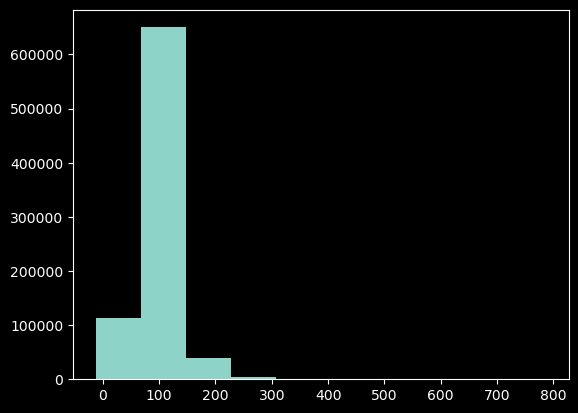

In [5]:
plt.hist(df_speed['speed'])

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
df_speed['log_speed']= np.log(df_speed['speed'])

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([1.00000e+00, 7.00000e+01, 4.00000e+01, 6.70000e+01, 2.79000e+02,
        5.07600e+03, 4.06444e+05, 3.78349e+05, 1.62370e+04, 7.42000e+02]),
 array([-0.56531381,  0.15810456,  0.88152293,  1.6049413 ,  2.32835967,
         3.05177803,  3.7751964 ,  4.49861477,  5.22203314,  5.94545151,
         6.66886988]),
 <BarContainer object of 10 artists>)

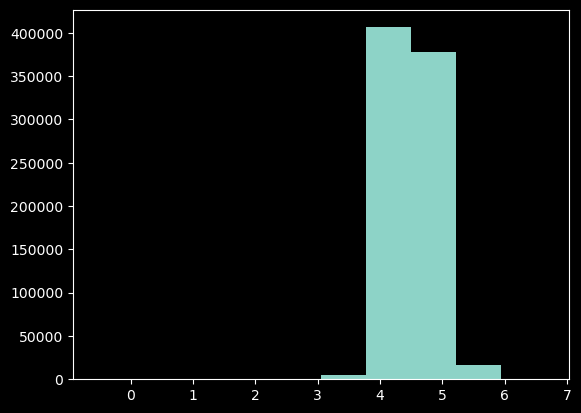

In [8]:
plt.hist(df_speed['log_speed'])

In [9]:
scaler = StandardScaler()
df_speed['log_speed_scaled']=scaler.fit_transform(df_speed[['log_speed']])

(array([1.00000e+00, 7.00000e+01, 4.00000e+01, 6.70000e+01, 2.79000e+02,
        5.07600e+03, 4.06444e+05, 3.78349e+05, 1.62370e+04, 7.42000e+02]),
 array([-1.65951236e+01, -1.42263591e+01, -1.18575946e+01, -9.48883003e+00,
        -7.12006550e+00, -4.75130096e+00, -2.38253642e+00, -1.37718884e-02,
         2.35499265e+00,  4.72375718e+00,  7.09252172e+00]),
 <BarContainer object of 10 artists>)

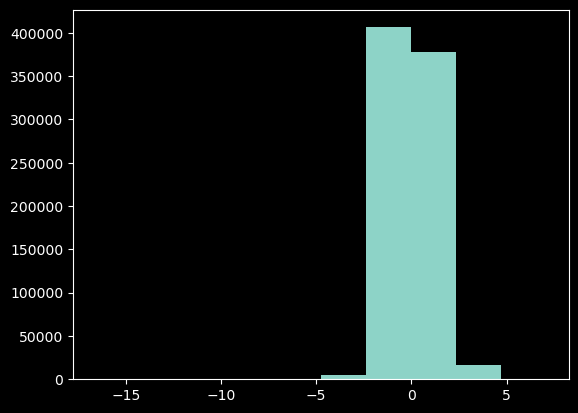

In [10]:
plt.hist(df_speed['log_speed_scaled'])

In [22]:
# Group by 'ID', 'segment', and 'Trial', then count the number of frames for each group
id_segment_counts = df_speed.groupby(['ID', 'segment', 'Trial']).size()

# Filter out ID-segment combinations that have less than 300 or more than 3000 frames
id_segments_to_keep = id_segment_counts[(id_segment_counts >= 300) & (id_segment_counts <= 5000)].index

# Keep only the rows where the combination of 'ID', 'segment', and 'Trial' is in the list of groups with frames between 300 and 3000
df_filtered = df_speed[df_speed.set_index(['ID', 'segment', 'Trial']).index.isin(id_segments_to_keep)]

#### Target sequence

In [24]:
# Step 1: Randomly sample 60 unique segments from the 'segment' column
unique_segments = df_filtered['segment'].drop_duplicates().sample(n=60, replace=False)

# Step 2: Filter the rows that correspond to the randomly selected unique segments
sampled_data = df_filtered[df_filtered['segment'].isin(unique_segments)]

# Step 3: Group by 'segment' and count the rows per segment
grouped_counts = sampled_data.groupby('segment').size()

# Step 4: Filter out segments with counts over 5000 or under 300
valid_segments = grouped_counts[(grouped_counts >= 300) & (grouped_counts <= 5000)].index

# Step 5: Filter the sampled data to keep only those segments with valid row counts
final_sampled_data = sampled_data[sampled_data['segment'].isin(valid_segments)]

# Display the final sampled data and the count of rows per segment
print(final_sampled_data.groupby('segment').size())

segment
6      3365
10      502
11     4366
14     3800
20     1117
21     4552
23     1742
27     3228
28     1020
29     2841
32     1068
33     4959
34      624
35     1972
36     3504
39     4451
40     2633
43     1199
44     2716
47      695
48     3033
51     4129
52     3394
54      606
55     1761
57     4511
58      326
59      474
60     1815
64      596
65      570
70     1393
71     2702
73     4951
75     2514
84     3631
86     2365
88     3399
157     328
dtype: int64


In [28]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm  # Progress bar
from concurrent.futures import ThreadPoolExecutor  # Parallel execution
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset (assuming df is your DataFrame)
df = final_sampled_data.copy()

# Ensure relevant columns are present
relevant_columns = ['ID', 'frame', 'headx', 'heady', 'midpoint_x', 'midpoint_y', 'log_speed_scaled', 'segment', 'Trial']
df = df[relevant_columns].dropna()  # Remove NaNs

# ✅ Step 1: Extract Positive Examples (with frame ordering and handling variable segment lengths)
print("\n🔄 Extracting positive examples (same segment)...")

# Sort rows by 'frame' within each group
df = df.sort_values(by=['segment', 'Trial', 'ID', 'frame'])

# Generate feature differences (positive examples)
df['headx_diff'] = df.groupby(['segment', 'Trial', 'ID'])['headx'].diff()
df['heady_diff'] = df.groupby(['segment', 'Trial', 'ID'])['heady'].diff()
df['midpoint_x_diff'] = df.groupby(['segment', 'Trial', 'ID'])['midpoint_x'].diff()
df['midpoint_y_diff'] = df.groupby(['segment', 'Trial', 'ID'])['midpoint_y'].diff()
df['log_speed_scaled_diff'] = df.groupby(['segment', 'Trial', 'ID'])['log_speed_scaled'].diff()

# Drop NaN rows (first frame in each group has no previous frame)
positive_samples = df.dropna(subset=['headx_diff']).copy()
positive_samples['same_segment'] = 1  # Label for correct pairs

print(f"✅ Extracted {len(positive_samples)} positive examples.\n")

# ✅ Step 2: Generate Negative Examples (Parallel Processing)
print("🔄 Generating negative examples (random segment pairs)...")

def generate_random_sample(df):
    """Randomly selects rows from different segments, Trials, or IDs and computes feature differences."""
    for _ in range(100):  # Retry 100 times to find valid pairs
        row1 = df.sample(1).iloc[0]
        row2 = df.sample(1).iloc[0]
        if row1['segment'] != row2['segment'] or row1['Trial'] != row2['Trial'] or row1['ID'] != row2['ID']:
            return {
                'headx_diff': row1['headx'] - row2['headx'],
                'heady_diff': row1['heady'] - row2['heady'],
                'midpoint_x_diff': row1['midpoint_x'] - row2['midpoint_x'],
                'midpoint_y_diff': row1['midpoint_y'] - row2['midpoint_y'],
                'log_speed_scaled_diff': row1['log_speed_scaled'] - row2['log_speed_scaled'],
                'same_segment': 0  # Incorrect classification
            }
    raise ValueError("Failed to generate a valid negative sample after 100 retries.")

# Generate negative examples in parallel
num_samples = int(len(positive_samples))  # 20% # Calculate the number of negative examples to generate / 0.80 * 0.20

with ThreadPoolExecutor() as executor:
    negative_samples = list(tqdm(executor.map(lambda _: generate_random_sample(df), range(num_samples)), 
                                  total=num_samples, desc="Generating Random Pairs"))

# ✅ Step 3: Combine Data
print("\n🔄 Combining positive and negative samples...")

# Convert negative samples to DataFrame
negative_samples_df = pd.DataFrame(negative_samples)

# Combine positive and negative samples
dataset = pd.concat([
    positive_samples[['headx_diff', 'heady_diff', 'midpoint_x_diff', 'midpoint_y_diff', 'log_speed_scaled_diff', 'same_segment']],
    negative_samples_df
], ignore_index=True)

# Define features and target
X = dataset.drop(columns=['same_segment'])
y = dataset['same_segment']

# Split into train/test (stratify ensures balance in splits)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Step 4: Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Step 5: Train Logistic Regression Model
print("\n🔄 Training Logistic Regression Model...")
model = LogisticRegression()
model.fit(X_train, y_train)

# ✅ Step 6: Predictions & Evaluation
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\n✅ Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)



🔄 Extracting positive examples (same segment)...
✅ Extracted 92362 positive examples.

🔄 Generating negative examples (random segment pairs)...


Generating Random Pairs: 100%|██████████████████████████████████████████████████| 92362/92362 [06:20<00:00, 242.95it/s]



🔄 Combining positive and negative samples...

🔄 Training Logistic Regression Model...

✅ Accuracy: 0.7372
Confusion Matrix:
 [[ 9122  9351]
 [  357 18115]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.49      0.65     18473
           1       0.66      0.98      0.79     18472

    accuracy                           0.74     36945
   macro avg       0.81      0.74      0.72     36945
weighted avg       0.81      0.74      0.72     36945



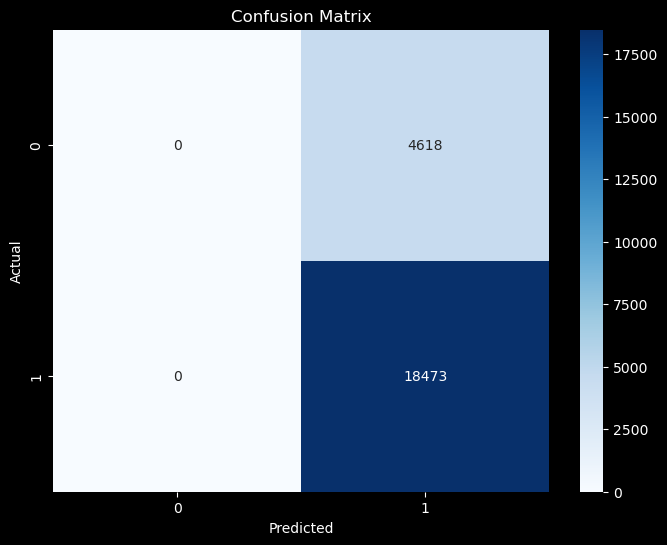

In [27]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Target carangids

Epoch 1/10


C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6587 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7571 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7719 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7801 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7641 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7893 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7715 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7640 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

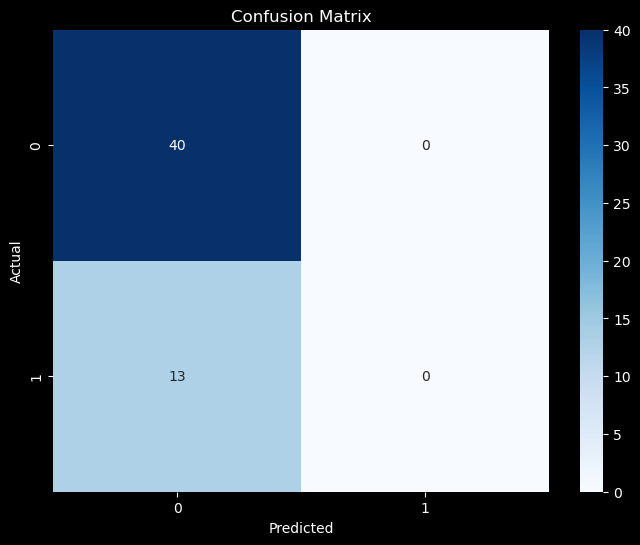

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = [trial_df['log_speed_scaled'].mean()]
    target = trial_df['carangids'].iloc[0]  # Assuming target is consistent per trial
    sequence_data.append(speeds)
    targets.append(target)

# Padding sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = np.array(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=False),  # Adjust units as needed
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/10


C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.7906 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.7793 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.7687 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.7500 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 60s 10s/step - accuracy: 0.7717 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 63s 11s/step - accuracy: 0.7610 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 12s/step - accuracy: 0.7462 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 74s 13s/step - accuracy: 0.7816 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 69s 11s/step - accuracy: 0.

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

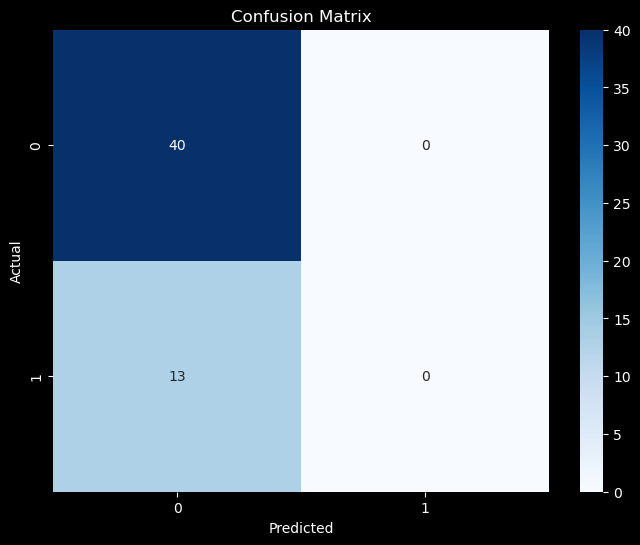

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'TimeDistributed' is not defined

In [17]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = trial_df['log_speed_scaled'].values
    target = trial_df['carangids'].iloc[0]  # Assuming target is consistent per trial
    sequence_data.append(speeds)
    targets.append(target)

# Padding sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = np.array(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=False),  # Adjust units as needed
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment','carangids']):
    speeds = trial_df['log_speed_scaled'].values
    target_sequence = trial_df['carangids'].values  # Full target sequence
    sequence_data.append(speeds)
    targets.append(target_sequence)

# Padding sequences for both inputs and outputs
max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = pad_sequences(targets, maxlen=max_len, padding='post', dtype='int')  # Ensure binary targets are padded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=True),  # Return sequences for multi-frame output
    TimeDistributed(Dense(1, activation='sigmoid'))  # Predict binary output for each frame
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten the outputs for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat))

# Confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [17]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'frame']):
    speeds = trial_df['log_speed_scaled'].values
    target_sequence = trial_df['carangids'].values  # Full target sequence
    sequence_data.append(speeds)
    targets.append(target_sequence)

# Padding sequences for both inputs and outputs
max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = pad_sequences(targets, maxlen=max_len, padding='post', dtype='float32')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model for sequence outputs
model = Sequential([
    Input(shape=(max_len, 1)),  # Explicit input shape
    Masking(mask_value=0.0),   # Handle padded values
    LSTM(50, activation='tanh', return_sequences=True),  # Output sequence for each time step
    Dense(1, activation='sigmoid')  # Binary classification for each time step
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict sequence outputs
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate performance for sequence predictions
# Flattening predictions and targets for classification metrics
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Remove padding effects for accuracy calculation
valid_indices = y_test_flat != 0  # Assuming padding values for `y` are zeros
y_test_valid = y_test_flat[valid_indices]
y_pred_valid = y_pred_flat[valid_indices]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_valid, y_pred_valid))

# Confusion matrix
cm = confusion_matrix(y_test_valid, y_pred_valid)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = [trial_df['log_speed_scaled'].mean()]
    target = trial_df['carangids'].iloc[0]  # Assuming target is consistent per trial
    sequence_data.append(speeds)
    targets.append(target)

# Padding sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = np.array(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=False),  # Adjust units as needed
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Acceleration 